In [ ]:
# Block 0: Mount your Google Drive
import torch
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


###DATASET FROM TMDB: Dataset 1 --> D1

Loaded raw dataset shape: (20000, 25)

All Genre Counts (raw):
Drama              6133
Comedy             3978
Documentary        3534
Romance            2025
Action             1765
Thriller           1670
Horror             1455
Animation          1275
Crime              1265
Music              1239
TV Movie           1121
Family              954
Adventure           688
Science Fiction     671
Fantasy             659
Mystery             571
History             449
War                 265
Western              73
dtype: int64

Logical Rationale:
We selected the following common genres (in blue) because they are widely produced, have broad audience appeal, and are suitable for a mass market including children and families:
['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller', 'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']

The following genres are excluded (in red) because they are either niche or have lower watchership according to our dataset, making them

<ipython-input-6-2807322c4ea3>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_genres_counts.index, y=all_genres_counts.values, palette=colors, edgecolor='black')


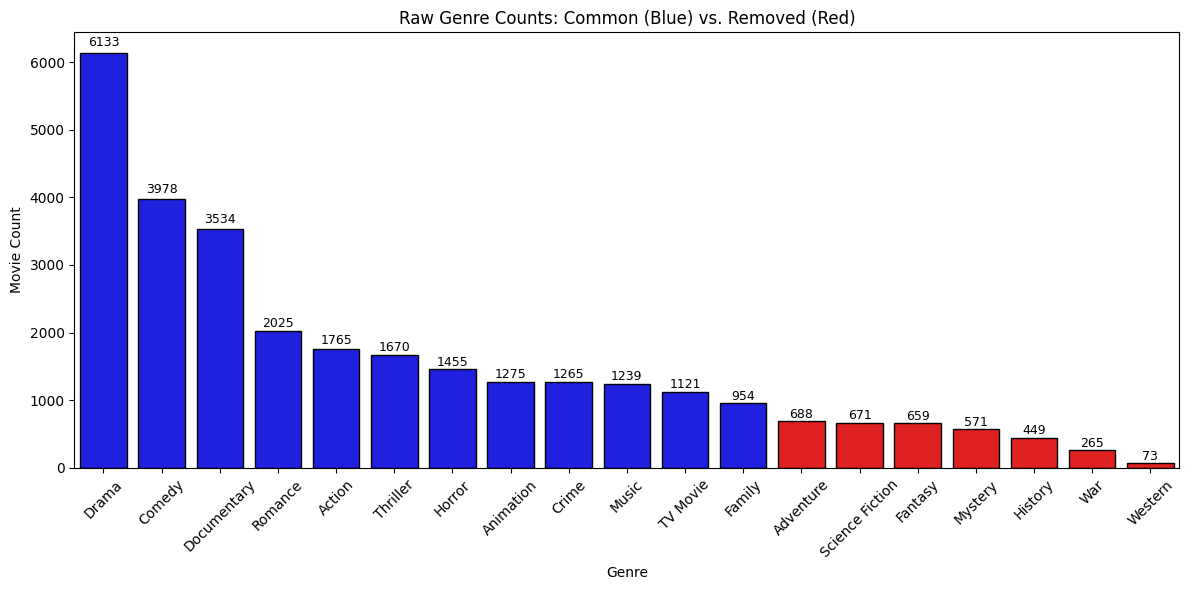

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1) Load the Raw CSV File
# ------------------------------
file_path = '/content/drive/MyDrive/Datasets/D1_TMDB.csv'
df_raw = pd.read_csv(file_path)
print("Loaded raw dataset shape:", df_raw.shape)

# ------------------------------
# 2) Process the 'genres' Column
# ------------------------------
# Often, the genres are stored as a string representation of a list.
def safe_convert(x):
    try:
        return eval(x)
    except:
        return []

df_raw['genres'] = df_raw['genres'].apply(safe_convert)

# ------------------------------
# 3) Compute Genre Counts for ALL Genres (before filtering)
# ------------------------------
genre_counts_all = {}
for genre_list in df_raw['genres']:
    for g in genre_list:
        genre_counts_all[g] = genre_counts_all.get(g, 0) + 1

all_genres_counts = pd.Series(genre_counts_all).sort_values(ascending=False)
print("\nAll Genre Counts (raw):")
print(all_genres_counts)

# ------------------------------
# 4) Define the Target (Common) Genres and Determine Removed Genres
# ------------------------------
# We want to focus on mainstream and widely watched genres,
# for instance, those suitable for children and the mass population.
# Here, we intentionally filter out niche genres such as Adventure, Fantasy,
# Science Fiction, History, Mystery, War, Western, etc.
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
                 'Action', 'Thriller', 'Horror', 'Crime',
                 'Music', 'Animation', 'TV Movie', 'Family']

# Identify genres that are in the raw counts but are not in our common_genres list.
removed_genres = [g for g in all_genres_counts.index if g not in common_genres]

print("\nLogical Rationale:")
print("We selected the following common genres (in blue) because they are widely produced, have broad audience appeal, and are suitable for a mass market including children and families:")
print(common_genres)
print("\nThe following genres are excluded (in red) because they are either niche or have lower watchership according to our dataset, making them less suitable for our primary analysis:")
print(removed_genres)

# ------------------------------
# 5) Create a Bar Chart to Visualize the Raw Genre Distribution
# ------------------------------
# Prepare color coding: common genres in blue; removed genres in red.
colors = []
for genre in all_genres_counts.index:
    if genre in common_genres:
        colors.append('blue')
    else:
        colors.append('red')

plt.figure(figsize=(12,6))
sns.barplot(x=all_genres_counts.index, y=all_genres_counts.values, palette=colors, edgecolor='black')
plt.title("Raw Genre Counts: Common (Blue) vs. Removed (Red)")
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.xticks(rotation=45)

# Annotate each bar with its count value.
for i, (genre, count) in enumerate(all_genres_counts.items()):
    plt.text(i, count + (count * 0.01), str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### CUSTOM DATASET FROM TMDB through API: Dataset 2 --> D2
1. Filtering the movies in 2 SETS:
    1.   Movies from 1975 to 2000
    2.   Movies from 2001 to 2025

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded raw dataset shape: (27901, 19)

All Genre Counts (raw):
Drama              9907
Comedy             7726
Thriller           5652
Action             5190
Romance            5092
Family             3997
Crime              3953
Horror             3888
Documentary        3832
Animation          3658
TV Movie           3626
Adventure          3500
Music              3490
Fantasy            2801
Science Fiction    2514
Mystery            2049
History            1013
War                 559
Western             308
dtype: int64

Logical Rationale:
We selected the following common genres (in blue) because they are widely produced, have broad audience appeal, and are suitable for a mass market including children and families:
['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller', 'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']

The fol

<ipython-input-7-2db477ababe9>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_genres_counts.index, y=all_genres_counts.values, palette=colors, edgecolor='black')


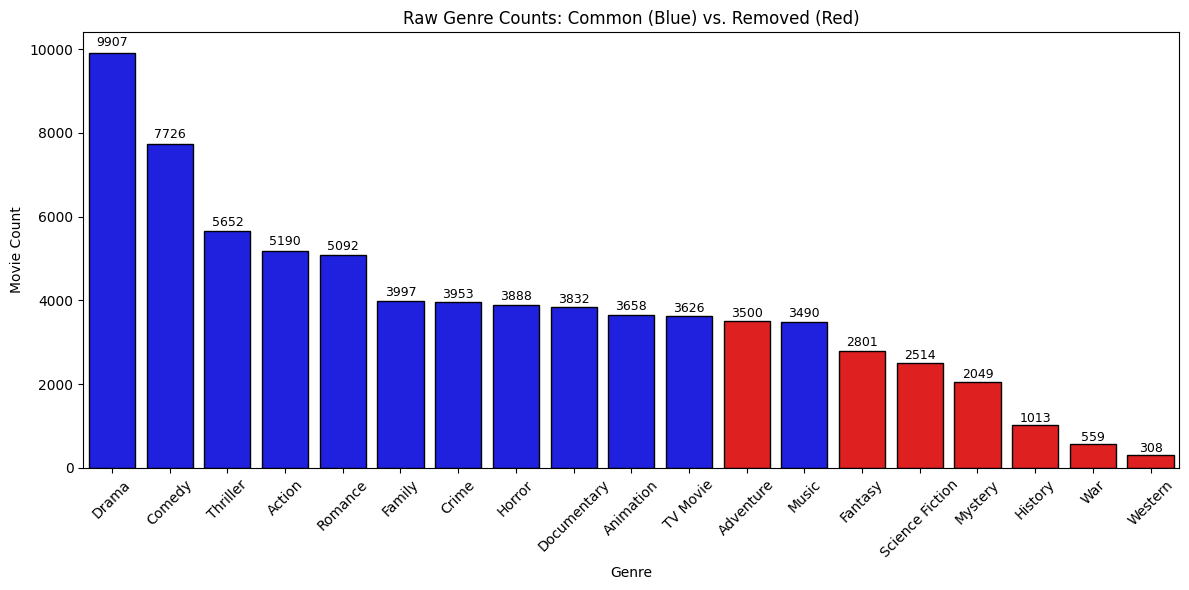

In [ ]:
# Combined Pipeline: CB1 to CB5
# This block mounts Google Drive, checks if the final CSV exists, and if not, runs the entire data collection and processing pipeline.
# The pipeline performs the following:
#   CB1: Environment Setup, Genre Mapping & Target Definitions
#   CB2: Fetch Movies Stratified by Genre using TMDB API
#   CB3: Combine and Deduplicate Movies, merging genre lists for multi-label movies
#   CB4: Download Poster Images for Each Movie
#   CB5: One-Hot Encode Genre Labels and Save the Final Balanced CSV

# -------------------------
# Block: Mount Drive
# -------------------------
from google.colab import drive
drive.mount('/content/drive')

# -------------------------
# Block CB1: Setup Environment, Paths, and Genre Definitions
# -------------------------
import os
import requests
import pandas as pd

# Define a new base folder to preserve this custom dataset (won't override previous data)
base_dataset_dir = '/content/drive/MyDrive/Datasets'
if not os.path.exists(base_dataset_dir):
    os.makedirs(base_dataset_dir)

# Define file paths for the final CSV and the poster folder
file_path= '/content/drive/MyDrive/Datasets/D2_TMDB_API.csv'

df_raw = pd.read_csv(file_path)
print("Loaded raw dataset shape:", df_raw.shape)

# ------------------------------
# 2) Process the 'genres' Column
# ------------------------------
# Often, the genres are stored as a string representation of a list.
def safe_convert(x):
    try:
        return eval(x)
    except:
        return []

df_raw['genres'] = df_raw['genres'].apply(safe_convert)

# ------------------------------
# 3) Compute Genre Counts for ALL Genres (before filtering)
# ------------------------------
genre_counts_all = {}
for genre_list in df_raw['genres']:
    for g in genre_list:
        genre_counts_all[g] = genre_counts_all.get(g, 0) + 1

all_genres_counts = pd.Series(genre_counts_all).sort_values(ascending=False)
print("\nAll Genre Counts (raw):")
print(all_genres_counts)

# ------------------------------
# 4) Define the Target (Common) Genres and Determine Removed Genres
# ------------------------------
# We want to focus on mainstream and widely watched genres,
# for instance, those suitable for children and the mass population.
# Here, we intentionally filter out niche genres such as Adventure, Fantasy,
# Science Fiction, History, Mystery, War, Western, etc.
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
                 'Action', 'Thriller', 'Horror', 'Crime',
                 'Music', 'Animation', 'TV Movie', 'Family']

# Identify genres that are in the raw counts but are not in our common_genres list.
removed_genres = [g for g in all_genres_counts.index if g not in common_genres]

print("\nLogical Rationale:")
print("We selected the following common genres (in blue) because they are widely produced, have broad audience appeal, and are suitable for a mass market including children and families:")
print(common_genres)
print("\nThe following genres are excluded (in red) because they are either niche or have lower watchership according to our dataset, making them less suitable for our primary analysis:")
print(removed_genres)

# ------------------------------
# 5) Create a Bar Chart to Visualize the Raw Genre Distribution
# ------------------------------
# Prepare color coding: common genres in blue; removed genres in red.
colors = []
for genre in all_genres_counts.index:
    if genre in common_genres:
        colors.append('blue')
    else:
        colors.append('red')

plt.figure(figsize=(12,6))
sns.barplot(x=all_genres_counts.index, y=all_genres_counts.values, palette=colors, edgecolor='black')
plt.title("Raw Genre Counts: Common (Blue) vs. Removed (Red)")
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.xticks(rotation=45)

# Annotate each bar with its count value.
for i, (genre, count) in enumerate(all_genres_counts.items()):
    plt.text(i, count + (count * 0.01), str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
# custom_poster_dir = os.path.join(base_dataset_dir, 'movie_posters')
# if not os.path.exists(custom_poster_dir):
#     os.makedirs(custom_poster_dir)

# # Define the target genres we want to work with.
# # These genres were selected because they are widely popular and suitable for a mass audience (including children and families).
# common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
#                  'Action', 'Thriller', 'Horror', 'Crime',
#                  'Music', 'Animation', 'TV Movie', 'Family']

# # TMDB API key (replace with your own key if necessary)
# API_KEY = 'd987d81a646fa33f4795a26f25fe7851'

# # Fetch the genre list from the TMDB API
# genres_url = f'https://api.themoviedb.org/3/genre/movie/list?api_key={API_KEY}'
# genres_response = requests.get(genres_url)
# genres_json = genres_response.json()
# if 'genres' not in genres_json:
#     raise Exception("Failed to fetch genres; please verify your API key and internet connectivity.")

# # Create genre mapping dictionaries:
# #   - genre_map: maps TMDB genre id to genre name
# #   - genre_map_inv: inverse mapping from genre name to id
# genre_map = {g['id']: g['name'] for g in genres_json['genres']}
# genre_map_inv = {v: k for k, v in genre_map.items()}

# print("Fetched TMDB Genre Mapping:")
# print(genre_map)
# print("\nTarget Common Genres:")
# print(common_genres)

# # Set desired sample count limits per genre (for stratified fetch)
# min_count = 2500
# max_count = 3500
# print(f"\nDesired movie count per genre: between {min_count} and {max_count}")

# # -------------------------
# # Check if the final CSV already exists; if so, load and skip the pipeline
# # -------------------------
# if os.path.exists(custom_csv_path):
#     print("\nFinal custom balanced movie metadata CSV already exists. Loading data...")
#     df_final = pd.read_csv(custom_csv_path)
#     print(f"Loaded dataset shape: {df_final.shape}")
# else:
#     print("\nFinal CSV not found. Running full pipeline (CB1 to CB5)...")

    # # -------------------------
    # # Block CB2: Fetch Movies Stratified by Genre
    # # -------------------------
    # import time
    # from tqdm import tqdm

    # # Initialize a dictionary to store movies for each genre
    # movies_by_genre = {genre: [] for genre in common_genres}

    # # Loop over each target genre and fetch movies using the TMDB Discover API
    # for genre in common_genres:
    #     genre_id = genre_map_inv.get(genre)
    #     print(f"\nFetching movies for genre: {genre} (ID: {genre_id})")
    #     page = 1
    #     while len(movies_by_genre[genre]) < max_count:
    #         discover_url = (
    #             f"https://api.themoviedb.org/3/discover/movie?api_key={API_KEY}"
    #             f"&language=en-US&sort_by=popularity.desc&include_adult=false"
    #             f"&include_video=false&with_genres={genre_id}&page={page}"
    #         )
    #         response = requests.get(discover_url)
    #         data = response.json()
    #         if 'results' not in data or len(data['results']) == 0:
    #             print(f"No more results for genre '{genre}' on page {page}.")
    #             break
    #         for movie in data['results']:
    #             # Only accept movies with a valid overview and poster path
    #             if movie.get('overview') and movie.get('poster_path'):
    #                 movie['source_genre'] = genre  # Tag the movie with its query genre
    #                 movies_by_genre[genre].append(movie)
    #                 if len(movies_by_genre[genre]) >= max_count:
    #                     break
    #         print(f"Genre '{genre}': Collected {len(movies_by_genre[genre])} movies (page {page})")
    #         page += 1
    #         time.sleep(0.25)  # Brief pause to prevent API rate limiting
    #     if len(movies_by_genre[genre]) < min_count:
    #         print(f"Warning: Only {len(movies_by_genre[genre])} movies found for genre '{genre}' (< min_count).")

    # # Print final count per genre for verification
    # for genre in common_genres:
    #     print(f"{genre}: {len(movies_by_genre[genre])} movies")

    # # -------------------------
    # # Block CB3: Combine and Deduplicate Movies
    # # -------------------------
    # # Combine movies from all genres
    # all_movies_list = []
    # for genre in common_genres:
    #     all_movies_list.extend(movies_by_genre[genre])

    # print(f"\nTotal movies collected before deduplication: {len(all_movies_list)}")

    # # Ensure every movie dictionary has a 'genres' key (if missing, fill using 'genre_ids')
    # for movie in all_movies_list:
    #     if 'genres' not in movie:
    #         if 'genre_ids' in movie and isinstance(movie.get('genre_ids'), list):
    #             movie['genres'] = [genre_map.get(gid, 'Unknown') for gid in movie.get('genre_ids', [])]
    #         else:
    #             movie['genres'] = []

    # # Create a DataFrame from the combined list
    # df_raw = pd.DataFrame(all_movies_list)

    # # Function to combine genres from duplicate entries (using set union)
    # def combine_genres(genres_series):
    #     merged = set()
    #     for genres in genres_series:
    #         if isinstance(genres, list):
    #             merged.update(genres)
    #     return list(merged)

    # # Group by movie 'id', taking the first appearance of text fields, and merge genre lists
    # df_grouped = df_raw.groupby('id').agg({
    #     'title': 'first',
    #     'overview': 'first',
    #     'poster_path': 'first',
    #     'source_genre': lambda x: list(set(x)),
    #     'genres': lambda x: combine_genres(x)
    # }).reset_index()

    # df_grouped.rename(columns={'id': 'movie_id'}, inplace=True)
    # print(f"Dataset shape after deduplication: {df_grouped.shape}")

    # # -------------------------
    # # Block CB4: Download Posters
    # # -------------------------
    # from tqdm import tqdm
    # import requests

    # os.makedirs(custom_poster_dir, exist_ok=True)

    # # Function to download a poster image for a given movie
    # def download_poster(movie):
    #     base_url = "https://image.tmdb.org/t/p/w500"
    #     poster_path = movie.get('poster_path')
    #     if poster_path:
    #         full_url = base_url + poster_path
    #         target_file = os.path.join(custom_poster_dir, f"{movie['movie_id']}.jpg")
    #         try:
    #             r = requests.get(full_url, timeout=10)
    #             if r.status_code == 200:
    #                 with open(target_file, 'wb') as f:
    #                     f.write(r.content)
    #                 return target_file
    #             else:
    #                 return None
    #         except Exception as e:
    #             print(f"Error downloading poster for movie {movie['movie_id']}: {e}")
    #             return None
    #     return None

    # # Download posters and save path to column 'poster_file'
    # df_grouped['poster_file'] = df_grouped.apply(lambda row: download_poster(row), axis=1)
    # print("Poster downloading completed.")

    # # -------------------------
    # # Block CB5: One-Hot Encode Genre Labels and Save Final CSV
    # # -------------------------
#     from sklearn.preprocessing import MultiLabelBinarizer

#     mlb = MultiLabelBinarizer(classes=common_genres)
#     genre_matrix = mlb.fit_transform(df_grouped['genres'])
#     genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)

#     # Concatenate the one-hot encoded DataFrame with df_grouped
#     df_final = pd.concat([df_grouped, genre_df], axis=1)

#     # Save the final custom balanced movie metadata CSV to disk
#     df_final.to_csv(custom_csv_path, index=False)
#     print(f"Final custom balanced movie metadata CSV saved to: {custom_csv_path}")

#     # Optionally, print final genre distribution
#     final_counts = df_final[common_genres].sum().sort_values(ascending=False)
#     print("\nFinal Genre Distribution:")
#     print(final_counts)

# # -------------------------
# # Checkpoint Complete:
# # At this point, df_final, common_genres, mlb, and final_counts are available for subsequent analysis and EDA.
# print("\nCheckpoint complete. All key variables are loaded for further analysis and model training.")


## FINAL DATASET TMDB: D1 + D2 = D3

In [ ]:
import pandas as pd

# 1. Read in both datasets
path1 = '/content/drive/MyDrive/Datasets/D1_TMDB.csv'
path2 = '/content/drive/MyDrive/Datasets/D2_TMDB_API.csv'

df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)

# 2. Compute the common columns
common_cols = list(set(df1.columns) & set(df2.columns))

# 3. Subset each to only those columns and concat
df = pd.concat([
    df1[common_cols],
    df2[common_cols]
], ignore_index=True)

# 4. Drop duplicate movies by ID (keep first occurence)
df = df.drop_duplicates(subset='movie_id')

# 5. Define which columns are metadata vs. genre flags
#    Here we treat these as metadata—adjust if you have others.
meta_cols = [
    'movie_id',
    'title',
    'overview',
    'poster_path',
    'poster_file',
    'genres'      # the textual list if you want to keep it
]

# Any common column not in meta_cols and of integer type → genre flag
genre_cols = [
    c for c in common_cols
    if c not in meta_cols and pd.api.types.is_integer_dtype(df[c])
]

print("Found genre columns:", genre_cols)

# 6. Figure out how many samples each genre currently has
genre_counts = df[genre_cols].sum().sort_values(ascending=False)
min_count = int(genre_counts.min())

print("\nCounts before balancing:")
print(genre_counts)
print(f"\nSampling each genre down to {min_count} examples.\n")

# 7. Undersample each genre to the smallest class size
frames = []
for g in genre_cols:
    sub = df[df[g] == 1]
    # if you wanted to oversample instead: sub.sample(min_count, replace=True)
    frames.append(sub.sample(min_count, random_state=42))

balanced = pd.concat(frames, ignore_index=True)

# Because movies can be multi‐label, drop any movie_id duplicates again
balanced = balanced.drop_duplicates(subset='movie_id')

# 8. Shuffle
balanced = balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Counts after balancing:")
print(balanced[genre_cols].sum().sort_values(ascending=False))

# 9. Save to a new CSV
out_path = 'balanced_tmdb_dataset.csv'
balanced.to_csv(out_path, index=False)
print(f"\nBalanced dataset saved to: {out_path}")


Found genre columns: ['Horror', 'Action', 'Drama', 'Family', 'TV Movie', 'Documentary', 'Romance', 'Comedy', 'Thriller', 'Crime', 'Music', 'Animation']

Counts before balancing:
Drama          15416
Comedy         11238
Documentary     7227
Thriller        6992
Romance         6831
Action          6658
Horror          5207
Crime           4975
Animation       4723
Family          4679
Music           4593
TV Movie        4472
dtype: int64

Sampling each genre down to 4472 examples.

Counts after balancing:
Drama          11910
Comedy          9249
Thriller        6463
Action          6025
Romance         5900
Documentary     5141
Crime           4841
Horror          4812
Animation       4635
Family          4622
Music           4530
TV Movie        4472
dtype: int64

Balanced dataset saved to: balanced_tmdb_dataset.csv


In [ ]:
import pandas as pd

# 1) Read both files
df1 = pd.read_csv('/content/drive/MyDrive/Datasets/D1_TMDB.csv')
df2 = pd.read_csv( '/content/drive/MyDrive/Datasets/D2_TMDB_API.csv')


# 2) Keep only columns they share, then concat & dedupe by movie_id
common = list(set(df1.columns) & set(df2.columns))
df = pd.concat([df1[common], df2[common]], ignore_index=True)
df = df.drop_duplicates(subset='movie_id').reset_index(drop=True)

# 3) Specify your genre-flag columns in the exact order you want on the right
genre_cols = [
    'Drama', 'Comedy', 'Documentary', 'Romance',
    'Action', 'Thriller', 'Horror', 'Crime',
    'Music', 'Animation', 'TV Movie', 'Family'
]
genre_cols = [g for g in genre_cols if g in df.columns]

# 4) Define “meta” columns (in the order you want them on the left)
left_meta = ['movie_id', 'title', 'overview', 'poster_path', 'poster_file', 'genres']
meta_cols = [c for c in left_meta if c in df.columns]

# 5) Add new features
df['title_length']    = df['title'].fillna('').str.len()
df['overview_length'] = df['overview'].fillna('').str.len()
df['num_genre']       = df[genre_cols].sum(axis=1).astype(int)

# 6) Build `source_genre` as a comma-separated list of every flagged genre
df['source_genre'] = df[genre_cols] \
    .apply(lambda row: ','.join([g for g,flag in row.items() if flag == 1]), axis=1)

# 7) Final column ordering:
final_cols = (
    meta_cols
    + ['title_length', 'overview_length', 'num_genre', 'source_genre']
    + genre_cols
)

# 8) Slice, shuffle, and save
df_final = df[final_cols].sample(frac=1, random_state=42).reset_index(drop=True)
df_final.to_csv('combined_tmdb.csv', index=False)

print("Done — here’s your columns:\n", df_final.columns.tolist())


Done — here’s your columns:
 ['movie_id', 'title', 'overview', 'poster_path', 'poster_file', 'genres', 'title_length', 'overview_length', 'num_genre', 'source_genre', 'Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller', 'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']


In [ ]:
# ─── Cell: Load from /content, remove duplicates, and save ────────────────────
import pandas as pd

# 1) Input & output paths
in_path  = '/content/combined_tmdb.csv'
out_path = '/content/drive/MyDrive/Datasets/D3_TMDB_combined.csv'

# 2) Load the combined file
df = pd.read_csv(in_path)

# 3) Drop duplicates by 'movie_id' (keep the first occurrence)
before = df.shape[0]
df = df.drop_duplicates(subset='movie_id', keep='first').reset_index(drop=True)
after = df.shape[0]

print(f"Dropped {before - after} duplicate rows based on 'movie_id'")

# 4) Save the deduplicated DataFrame
df.to_csv(out_path, index=False)
print(f"Deduplicated file saved to: {out_path} (shape: {df.shape})")


Dropped 0 duplicate rows based on 'movie_id'
Deduplicated file saved to: /content/drive/MyDrive/Datasets/D3_TMDB_combined.csv (shape: (46446, 22))


In [ ]:
# Checkpoint: Load Final Custom Balanced Dataset and Setup Variables for EDA

import os
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# --- Step 2: Define the file path and common genres ---
# Update the path if needed (this should be the same as used in CB1-CB5)
custom_csv_path = '/content/drive/MyDrive/Datasets/D3_TMDB_combined.csv'

# Define common_genres (make sure this is the same list used earlier)
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
                 'Action', 'Thriller', 'Horror', 'Crime',
                 'Music', 'Animation', 'TV Movie', 'Family']

# --- Step 3: Load the Final Balanced CSV ---
if os.path.exists(custom_csv_path):
    print("Final custom balanced movie metadata CSV found. Loading data...")
    df_final = pd.read_csv(custom_csv_path)
    print(f"Loaded dataset shape: {df_final.shape}")
else:
    raise FileNotFoundError("Final balanced CSV not found. Please run Blocks CB1–CB5 first.")

# --- Step 4: Check for One-Hot Encoded Genre Columns ---
# We expect that the final CSV contains one-hot encoded columns corresponding to common_genres.
missing_genre_cols = [genre for genre in common_genres if genre not in df_final.columns]
if missing_genre_cols:
    print("The following genre columns are missing:", missing_genre_cols)
    print("Re-creating one-hot encoded genre columns from 'genres' column...")
    # Ensure the 'genres' column is a list (if stored as a string, we attempt evaluation)
    def safe_convert(x):
        if isinstance(x, str):
            try:
                return eval(x)
            except:
                return []
        return x
    df_final['genres'] = df_final['genres'].apply(safe_convert)

    mlb = MultiLabelBinarizer(classes=common_genres)
    genre_matrix = mlb.fit_transform(df_final['genres'])
    genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)
    df_final = pd.concat([df_final, genre_df], axis=1)
    print("One-hot encoding complete.")
else:
    print("One-hot encoded genre columns exist.")
    # Optionally, create an instance of MultiLabelBinarizer for later use in EDA.
    mlb = MultiLabelBinarizer(classes=common_genres)

# --- Step 5: Compute Final Genre Distribution and Print Evaluation Metrics ---
final_counts = df_final[common_genres].sum().sort_values(ascending=False)
print("\nFinal Genre Distribution:")
print(final_counts)

# Save final_counts to a variable for use in EDA blocks
# (You can now directly reference df_final, common_genres, mlb, and final_counts in subsequent analyses)
print("\nCheckpoint complete. All key variables are loaded for EDA.")


Final custom balanced movie metadata CSV found. Loading data...
Loaded dataset shape: (46446, 22)
One-hot encoded genre columns exist.

Final Genre Distribution:
Drama          15416
Comedy         11238
Documentary     7227
Thriller        6992
Romance         6831
Action          6658
Horror          5207
Crime           4975
Animation       4723
Family          4679
Music           4593
TV Movie        4472
dtype: int64

Checkpoint complete. All key variables are loaded for EDA.


In [ ]:
# Block E3: Genre Distribution – Descriptive Statistics

import numpy as np
import scipy.stats as stats

# Define common_genres (if not already defined)
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
                 'Action', 'Thriller', 'Horror', 'Crime',
                 'Music', 'Animation', 'TV Movie', 'Family']

# # Calculate final genre counts
# final_counts = df_final[common_genres].sum().sort_values(ascending=False)
# print("Final Genre Distribution:")
# print(final_counts)

# Compute evaluation metrics for genre counts
mean_genres = final_counts.mean()
median_genres = final_counts.median()
std_genres = final_counts.std()
skew_genres = stats.skew(final_counts.values, bias=False)
kurtosis_genres = stats.kurtosis(final_counts.values, fisher=True)
min_genres = final_counts.min()
max_genres = final_counts.max()
iqr_genres = np.percentile(final_counts, 75) - np.percentile(final_counts, 25)

print("\nGenre Count Evaluation Metrics:")
print(f"Mean: {mean_genres:.2f}")
print(f"Median: {median_genres:.2f}")
print(f"Standard Deviation: {std_genres:.2f}")
print(f"Skewness: {skew_genres:.2f}")
print(f"Kurtosis: {kurtosis_genres:.2f}")
print(f"Min: {min_genres}")
print(f"Max: {max_genres}")
print(f"IQR: {iqr_genres:.2f}")



Genre Count Evaluation Metrics:
Mean: 6917.58
Median: 5932.50
Standard Deviation: 3288.78
Skewness: 1.94
Kurtosis: 1.83
Min: 4472
Max: 15416
IQR: 2338.75


<ipython-input-14-a0118e0a49ee>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_counts.index, y=final_counts.values, palette='viridis')


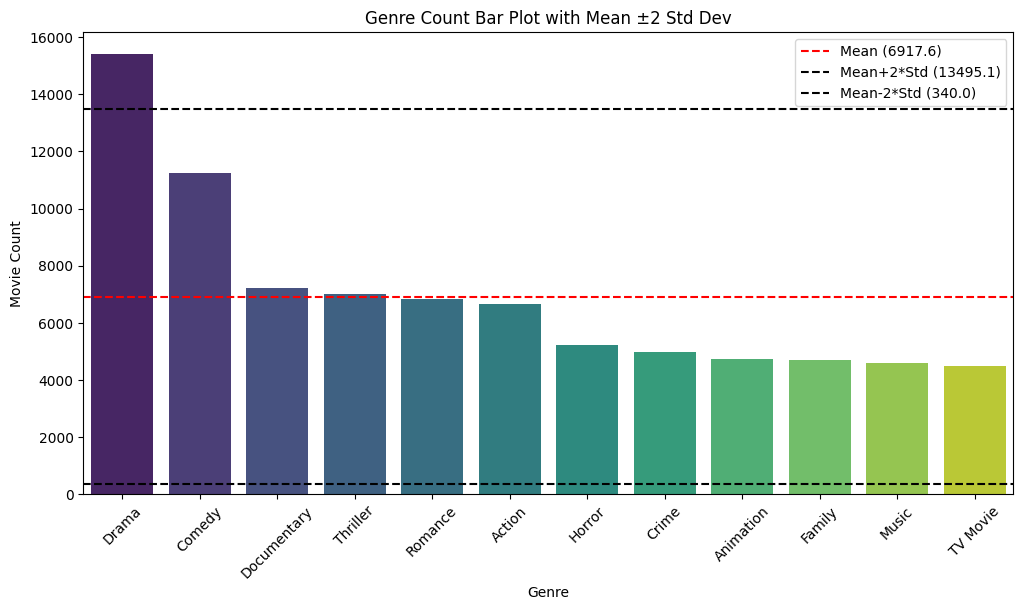

In [ ]:
# Block E4: Genre Count Bar Plot with Normal Overlays
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(x=final_counts.index, y=final_counts.values, palette='viridis')
plt.axhline(mean_genres, color='red', linestyle='--', label=f'Mean ({mean_genres:.1f})')
plt.axhline(mean_genres + 2*std_genres, color='black', linestyle='--', label=f'Mean+2*Std ({mean_genres+2*std_genres:.1f})')
plt.axhline(mean_genres - 2*std_genres, color='black', linestyle='--', label=f'Mean-2*Std ({mean_genres-2*std_genres:.1f})')
plt.title("Genre Count Bar Plot with Mean ±2 Std Dev")
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [ ]:
# Block U1: Compute Drop Probabilities for Majority Genres

import numpy as np
import pandas as pd
import scipy.stats as stats

# Define target count for majority genres (choose a value that reduces the skew)
target = 5000

# Ensure common_genres is defined
common_genres = ['Drama', 'Comedy', 'Documentary', 'Romance',
                 'Action', 'Thriller', 'Horror', 'Crime',
                 'Music', 'Animation', 'TV Movie', 'Family']

# Calculate final genre counts from df_final
final_counts = df_final[common_genres].sum().sort_values(ascending=False)
print("Original Genre Distribution:")
print(final_counts)

# Calculate drop probability for each genre: only if count > target
drop_prob_dict = {}
for genre, count in final_counts.items():
    if count > target:
        drop_prob_dict[genre] = 1 - (target / count)
    else:
        drop_prob_dict[genre] = 0

print("\nDrop Probabilities per Genre:")
for genre, p in drop_prob_dict.items():
    print(f"{genre}: {p:.3f}")


Original Genre Distribution:
Drama          15416
Comedy         11238
Documentary     7227
Thriller        6992
Romance         6831
Action          6658
Horror          5207
Crime           4975
Animation       4723
Family          4679
Music           4593
TV Movie        4472
dtype: int64

Drop Probabilities per Genre:
Drama: 0.676
Comedy: 0.555
Documentary: 0.308
Thriller: 0.285
Romance: 0.268
Action: 0.249
Horror: 0.040
Crime: 0.000
Animation: 0.000
Family: 0.000
Music: 0.000
TV Movie: 0.000


In [ ]:
# Block U2: Apply Undersampling to Reduce Overrepresentation

import numpy as np

# Function to compute the maximum drop probability for a row based on its majority labels
def compute_row_drop_probability(row):
    probs = []
    for genre in common_genres:
        # Check if row has this genre and if the drop probability for the genre is greater than 0
        if row[genre] == 1 and drop_prob_dict[genre] > 0:
            probs.append(drop_prob_dict[genre])
    return max(probs) if probs else 0

# Set random seed for reproducibility
np.random.seed(42)

# Apply undersampling: retain a row with probability = 1 - (max drop probability for that row)
mask = df_final.apply(lambda row: np.random.uniform(0,1) >= compute_row_drop_probability(row), axis=1)
df_under = df_final[mask].copy()

print("\nUndersampled dataset shape:", df_under.shape)

# Calculate the new genre distribution after undersampling
new_genre_counts_under = df_under[common_genres].sum().sort_values(ascending=False)
print("\nNew Genre Distribution After Undersampling:")
print(new_genre_counts_under)



Undersampled dataset shape: (27270, 22)

New Genre Distribution After Undersampling:
Drama          4989
Documentary    4869
Comedy         4623
Thriller       3844
Action         3716
Horror         3611
Animation      3218
Romance        2877
Music          2842
Family         2804
Crime          2411
TV Movie       2326
dtype: int64


<ipython-input-17-cff9b8959a29>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=new_genre_counts_under.index, y=new_genre_counts_under.values, palette='viridis')


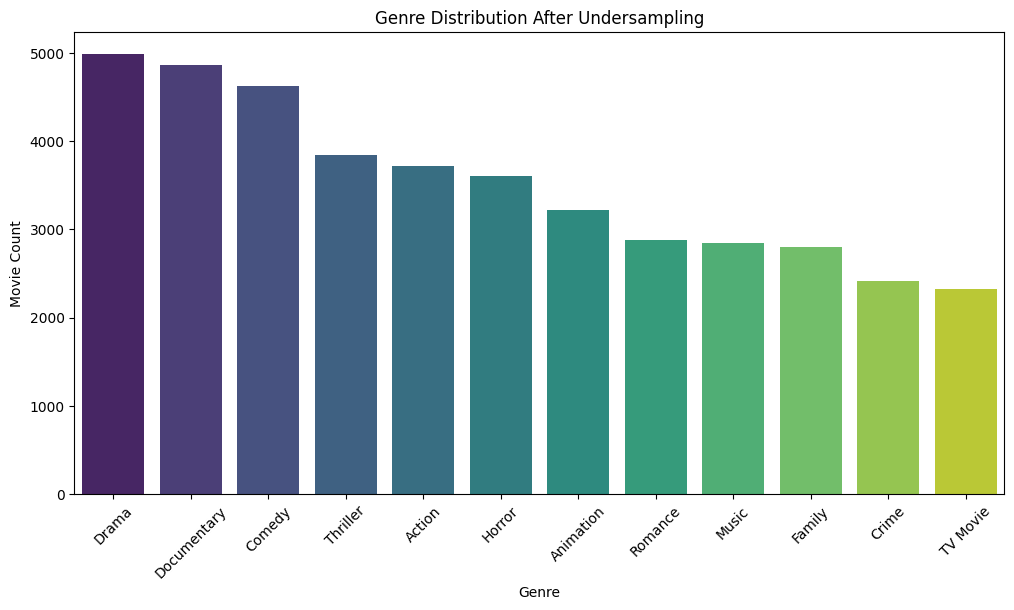

In [ ]:
# Block U3: Plot Genre Distribution After Undersampling

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(x=new_genre_counts_under.index, y=new_genre_counts_under.values, palette='viridis')
plt.title("Genre Distribution After Undersampling")
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Block U7: Save the Undersampled Dataset to CSV for Model Training

import os

# Define the new file path in your custom base folder
undersampled_csv_path = os.path.join('/content/drive/MyDrive/Datasets', 'undersampled_TMDB.csv')

# Save the undersampled DataFrame (df_under) to a CSV file without the index column
df_under.to_csv(undersampled_csv_path, index=False)

print(f"Undersampled movie metadata CSV saved to: {undersampled_csv_path}")


Undersampled movie metadata CSV saved to: /content/drive/MyDrive/Datasets/undersampled_TMDB.csv


In [ ]:
undersampled_csv_path = '/content/drive/MyDrive/Datasets/undersampled_TMDB.csv'
df_final = pd.read_csv(undersampled_csv_path)


In [ ]:
import pandas as pd

# 1) Load your undersampled CSV
undersampled_csv_path = '/content/drive/MyDrive/Datasets/undersampled_TMDB.csv'
df_final = pd.read_csv(undersampled_csv_path)

# 2) Define your one-hot genre columns (in the same order you used before)
genre_cols = [
    'Drama', 'Comedy', 'Documentary', 'Romance',
    'Action', 'Thriller', 'Horror', 'Crime',
    'Music', 'Animation', 'TV Movie', 'Family'
]

# 3) Drop any rows where all genre flags are zero
mask_no_genre = df_final[genre_cols].sum(axis=1) == 0
print(f"Removing {mask_no_genre.sum()} rows with no genres.")
df_final = df_final.loc[~mask_no_genre].reset_index(drop=True)

# 4) (Optional) Also drop rows with empty source_genre
# df_final = df_final[df_final['source_genre'].notna() & (df_final['source_genre'] != '')]

# 5) Save the cleaned file back out
df_final.to_csv(undersampled_csv_path, index=False)
print(f"Cleaned file saved ({df_final.shape[0]} rows remain).")


Removing 3625 rows with no genres.
Cleaned file saved (23645 rows remain).


In [ ]:
# ─── Cell: Convert `source_genre` from comma-string to Python list ─────────────────

import pandas as pd

# (Re)load your DataFrame
undersampled_csv_path = '/content/drive/MyDrive/Datasets/undersampled_TMDB.csv'
df = pd.read_csv(undersampled_csv_path)

# Turn each "Drama,Comedy" string into ['Drama','Comedy']
df['source_genre'] = (
    df['source_genre']
      .fillna('')                                    # replace NaN with empty string
      .astype(str)                                   # ensure it’s a string
      .apply(lambda s: [g.strip() for g in s.split(',')] if s else [])
)

# Save back if you like
df.to_csv(undersampled_csv_path, index=False)

# Quick check
print(df['source_genre'].head(10))


0                      [Drama, Comedy]
1                      [Drama, Action]
2              [Drama, Comedy, Family]
3                   [Thriller, Horror]
4                 [Documentary, Music]
5                   [Thriller, Horror]
6                     [Drama, Romance]
7                   [Thriller, Horror]
8    [Action, Thriller, Horror, Crime]
9                          [Animation]
Name: source_genre, dtype: object


In [ ]:
# Block P1: Poster Metadata Quality

import os

# Count total records and those with non-null poster_file
total_posters = len(df_final)
non_null_posters = df_final['poster_file'].notnull().sum()

# Check file existence for a sample (or all) poster_file paths
df_final['poster_exists'] = df_final['poster_file'].apply(lambda x: os.path.exists(x) if pd.notnull(x) else False)
files_exist = df_final['poster_exists'].sum()

print("Poster Metadata Quality:")
print(f"Total records: {total_posters}")
print(f"Non-null poster_file entries: {non_null_posters}")
print(f"Poster files found on disk: {files_exist}")


Poster Metadata Quality:
Total records: 23645
Non-null poster_file entries: 23645
Poster files found on disk: 0


Additional Metadata Cleaning Metrics:
Missing overviews: 0
Missing titles: 0
Duplicate movie_id count: 0

Title Length Statistics:
count    23645.000000
mean        20.164263
std         12.728211
min          1.000000
25%         11.000000
50%         17.000000
75%         26.000000
max        150.000000
Name: title_length, dtype: float64


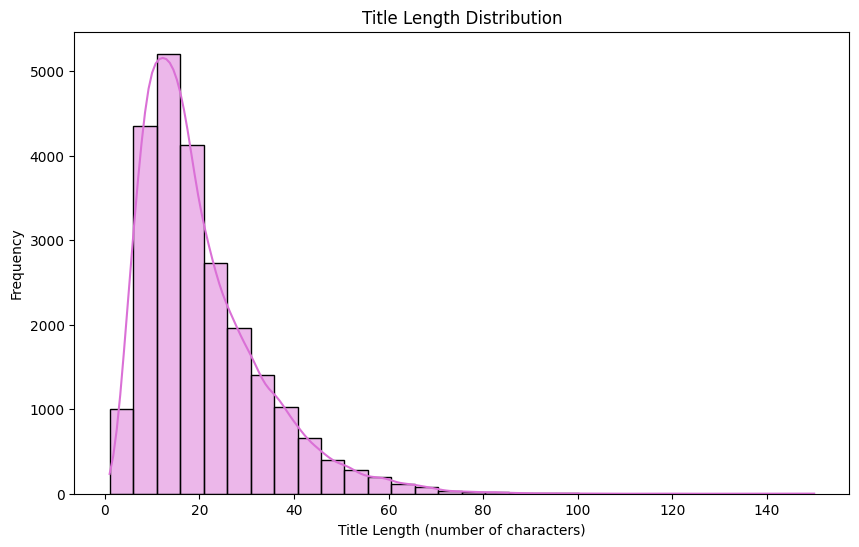

In [ ]:
# Block E8: Additional Metadata Quality Metrics (Text)

# Count of missing overviews and titles
missing_overviews = df_final['overview'].isnull().sum()
missing_titles = df_final['title'].isnull().sum()

# Duplicate count based on movie_id (should be 0 after deduplication)
duplicate_count = df_final.duplicated(subset=['movie_id']).sum()

# Title length distribution
df_final['title_length'] = df_final['title'].apply(lambda x: len(str(x)))
title_stats = df_final['title_length'].describe()

print("Additional Metadata Cleaning Metrics:")
print(f"Missing overviews: {missing_overviews}")
print(f"Missing titles: {missing_titles}")
print(f"Duplicate movie_id count: {duplicate_count}")
print("\nTitle Length Statistics:")
print(title_stats)

# Plot title length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_final['title_length'], bins=30, kde=True, color='orchid', edgecolor='black')
plt.title("Title Length Distribution")
plt.xlabel("Title Length (number of characters)")
plt.ylabel("Frequency")
plt.show()


Overview Length Evaluation Metrics:
Mean: 50.19
Median: 42.00
Standard Deviation: 32.06
Skewness: 1.23
Kurtosis: 1.42
Min: 0
Max: 187
IQR: 40.00


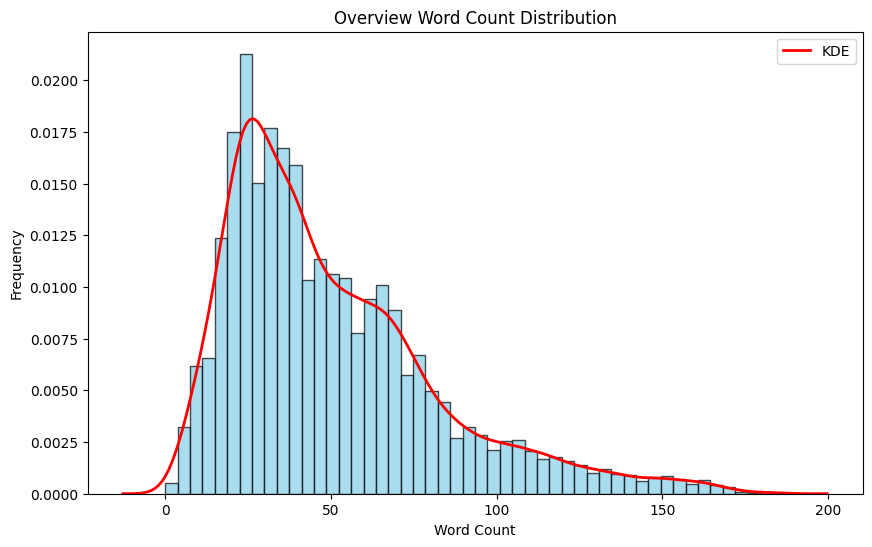

In [ ]:
# Block E2: Overview (Text) Length Analysis

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# If not already present, calculate overview word count.
if 'overview_word_count' not in df_final.columns:
    df_final['overview_word_count'] = df_final['overview'].apply(lambda x: len(str(x).split()))

overview_lengths = df_final['overview_word_count']

# Evaluation metrics
mean_len = overview_lengths.mean()
median_len = overview_lengths.median()
std_len = overview_lengths.std()
skew_len = stats.skew(overview_lengths, bias=False)
kurtosis_len = stats.kurtosis(overview_lengths, fisher=True)
min_len = overview_lengths.min()
max_len = overview_lengths.max()
iqr_len = np.percentile(overview_lengths, 75) - np.percentile(overview_lengths, 25)

print("Overview Length Evaluation Metrics:")
print(f"Mean: {mean_len:.2f}")
print(f"Median: {median_len:.2f}")
print(f"Standard Deviation: {std_len:.2f}")
print(f"Skewness: {skew_len:.2f}")
print(f"Kurtosis: {kurtosis_len:.2f}")
print(f"Min: {min_len}")
print(f"Max: {max_len}")
print(f"IQR: {iqr_len:.2f}")

# Plot histogram with KDE for overview lengths
plt.figure(figsize=(10, 6))
plt.title("Overview Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.hist(overview_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)
sns.kdeplot(overview_lengths, color='red', lw=2, label="KDE")
plt.legend()
plt.show()


Number of genres per movie statistics:
count    23645.000000
mean         1.781772
std          0.839414
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          6.000000
Name: num_genres, dtype: float64


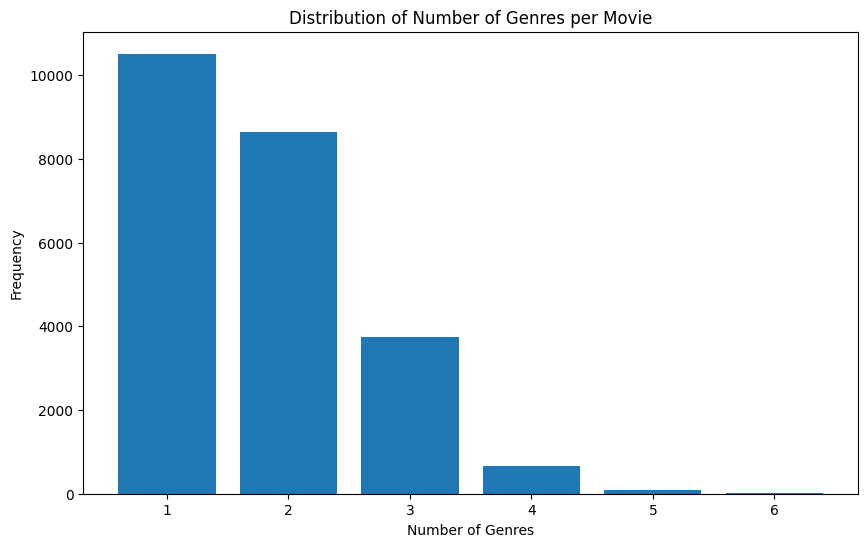

In [ ]:
# Enhanced EDA: Number of Genres per Movie
import matplotlib.pyplot as plt

# Calculate number of genres per movie
df_final['num_genres'] = df_final[common_genres].sum(axis=1)

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(df_final['num_genres'], bins=range(1, df_final['num_genres'].max()+2), align='left', rwidth=0.8)
plt.title('Distribution of Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.xticks(range(1, df_final['num_genres'].max()+1))
plt.savefig('num_genres_histogram.png')

# Print statistics
print("Number of genres per movie statistics:")
print(df_final['num_genres'].describe())

# Enhanced EDA: Genre Co-occurrence Matrix
import seaborn as sns

# Compute co-occurrence matrix
co_occurrence = df_final[common_genres].T.dot(df_final[common_genres])


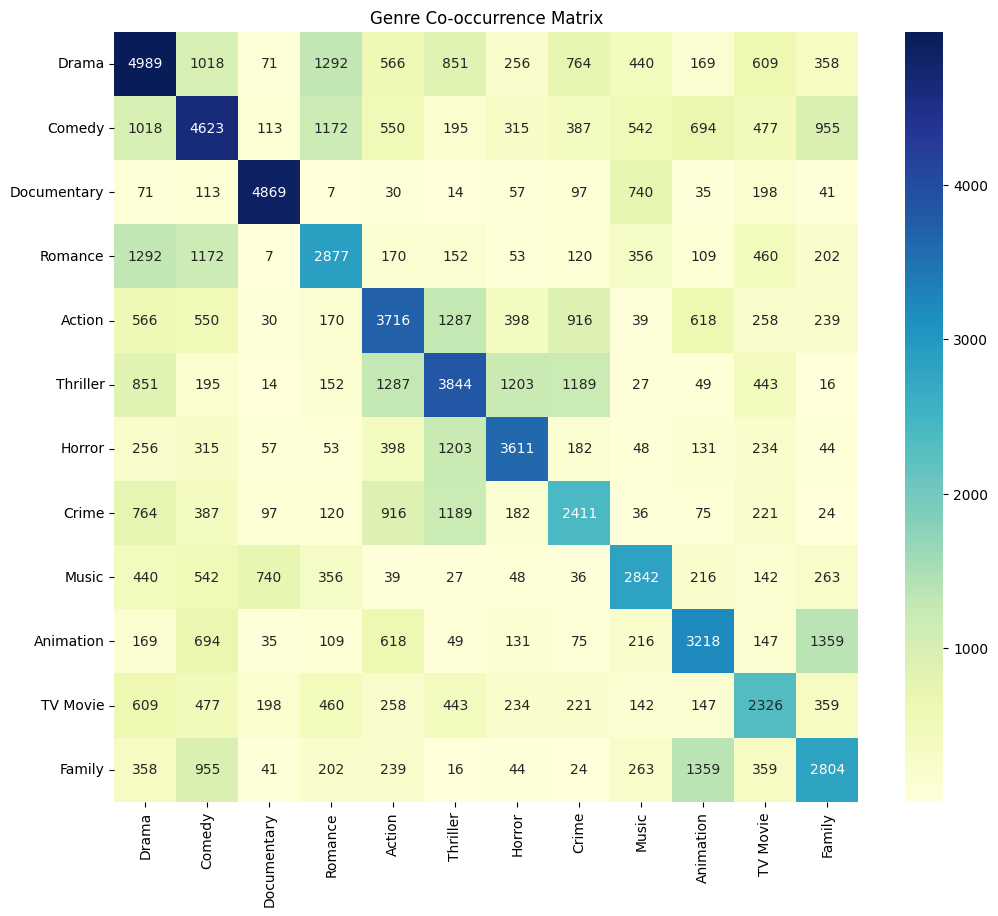

In [ ]:
# Plot heatmap showing relation between genres
plt.figure(figsize=(12,10))
sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Genre Co-occurrence Matrix')
plt.savefig('genre_cooccurrence_heatmap.png')

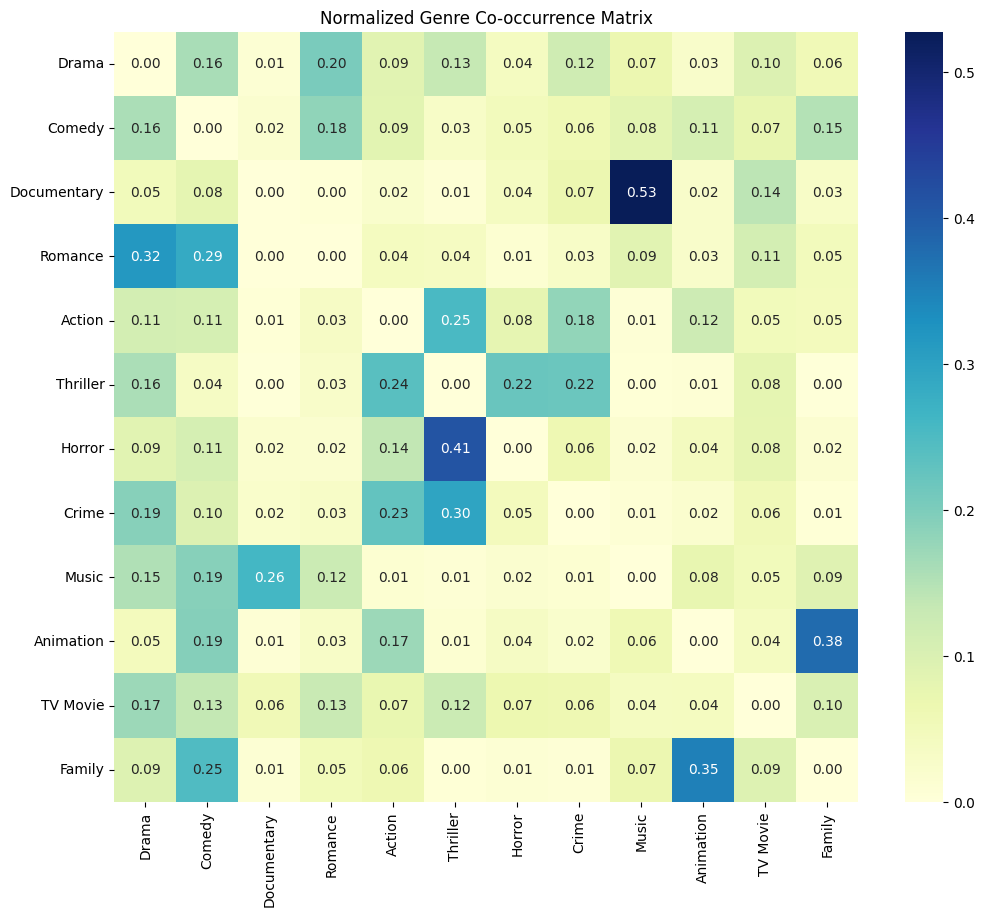

In [ ]:
# 3. Extended Genre Co-occurrence Matrix with Normalization
co_occurrence = df_final[common_genres].T.dot(df_final[common_genres])
np.fill_diagonal(co_occurrence.values, 0)  # Remove self-co-occurrences
co_occurrence_normalized = co_occurrence.div(co_occurrence.sum(axis=1), axis=0)
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_normalized, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Normalized Genre Co-occurrence Matrix')
plt.savefig('normalized_genre_cooccurrence.png')

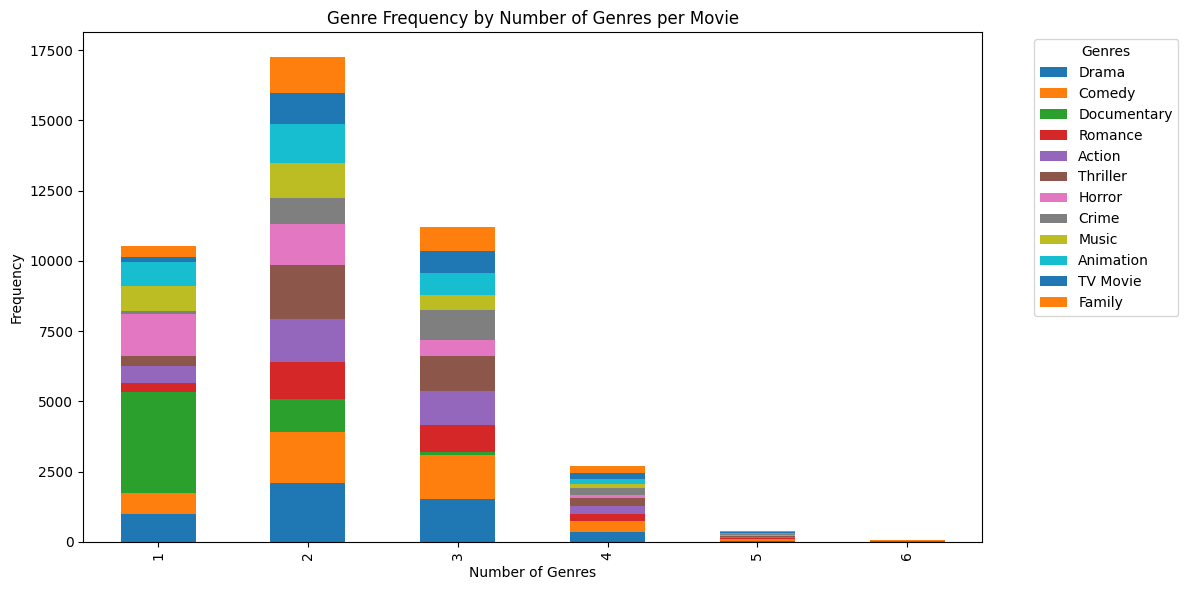

In [ ]:
import matplotlib.pyplot as plt
#Shows mapping frequency of movies in genres  there
genre_freq_by_count = df_final.groupby('num_genres')[common_genres].sum()
genre_freq_by_count.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Genre Frequency by Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('genre_freq_by_count.png')

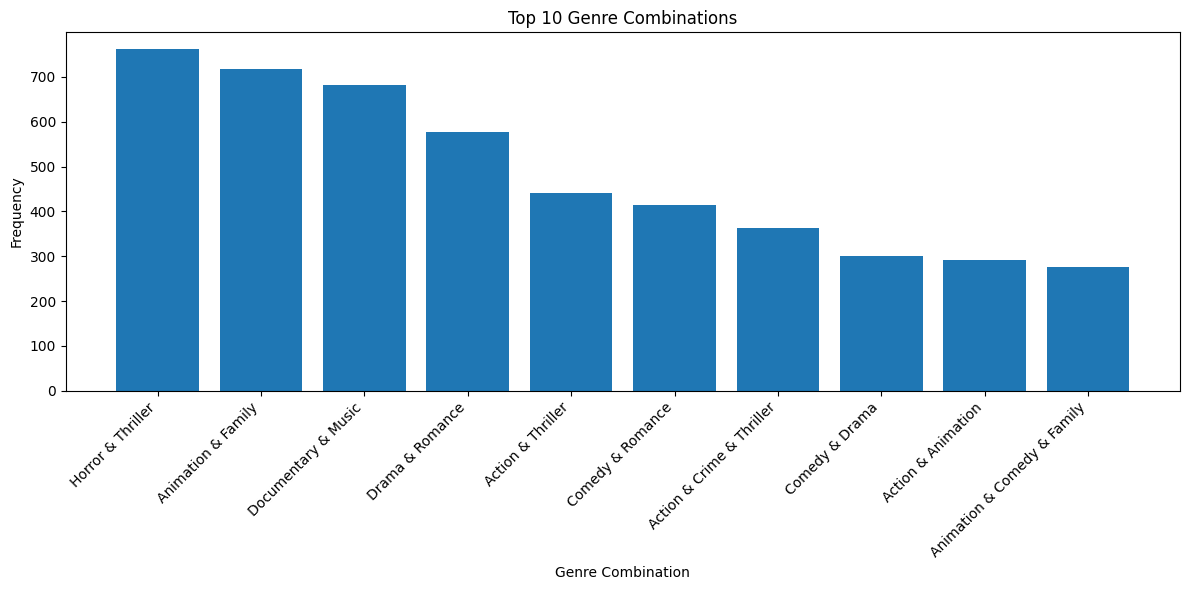

In [ ]:
# 5. Top Genre Combinations with Frequency
from collections import Counter
genre_combos = df_final[df_final[common_genres].sum(axis=1) > 1].apply(
    lambda row: tuple(sorted([genre for genre in common_genres if row[genre] == 1])), axis=1)
combo_counts = Counter(genre_combos)
N = 10
top_combos = combo_counts.most_common(N)
combo_labels = [' & '.join(combo) for combo, _ in top_combos]
combo_freqs = [freq for _, freq in top_combos]
plt.figure(figsize=(12, 6))
plt.bar(combo_labels, combo_freqs)
plt.title(f'Top {N} Genre Combinations')
plt.xlabel('Genre Combination')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_genre_combinations.png')

#LSTM + GLOVe Embeddings

In [11]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install gensim

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2


In [1]:
#Load pre-trained GloVe embeddings
# import gensim.downloader as api
from gensim.models import KeyedVectors

embedding_path = "/content/drive/MyDrive/Embeddings/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz"
embeddings = KeyedVectors.load_word2vec_format(embedding_path, binary=False)
# glove_model = api.load("glove-wiki-gigaword-100")

In [1]:
import os
from pathlib import Path
import requests
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns
import numpy as np
import ast
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# warnings.filterwarnings('ignore', category= Warning)
import json
import cuda
# Import required modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import requests
from sklearn.preprocessing import MultiLabelBinarizer
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#for text preprocessing
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
#List of stops words in English
from nltk.corpus import stopwords
#stopwords.words('english')
nltk.download('wordnet')
lemma = WordNetLemmatizer()
import torch
from collections import Counter
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from collections import defaultdict
from keras.preprocessing.sequence import pad_sequences
from transformers import WordpieceTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
csv_path = '/content/drive/MyDrive/ColabNotebooks/undersampled_TMDB.csv'
df = pd.read_csv(csv_path)
df.head()

,movie_id,title,overview,poster_path,poster_file,genres,title_length,overview_length,num_genre,source_genre,...,Documentary,Romance,Action,Thriller,Horror,Crime,Music,Animation,TV Movie,Family
0,86497,Wide Open,A philandering cab driver decides to help his ...,/uzIFp9Wu4QPyTJ1eqgkcIVYud7S.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Comedy', 'Drama']",9,114,2,"['Drama', 'Comedy']",...,0,0,0,0,0,0,0,0,0,0
1,16219,Gladiator,Tommy Riley has moved with his dad to Chicago ...,/w0YjBWVfu689txEXZG3xa4Aev3i.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Drama', 'Action']",9,236,2,"['Drama', 'Action']",...,0,0,1,0,0,0,0,0,0,0
2,512062,Vinayapoorvam Vidyadharan,"Vidyadharan is a bank employee, who loses his ...",/t4P0xquN818fyhMdsCsGR5BecV5.jpg,/content/drive/MyDrive/Tmdb_posters/movie_post...,"['Comedy', 'Family', 'Drama']",25,172,3,"['Drama', 'Comedy', 'Family']",...,0,0,0,0,0,0,0,0,0,1
3,43089,Roadgames,A truck driver plays a cat-and-mouse game with...,/zj3eE1lNkp3oWWnOHu4Aj7Gkqj2.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Thriller', 'Mystery', 'Horror']",9,158,2,"['Thriller', 'Horror']",...,0,0,0,1,1,0,0,0,0,0
4,270016,Elvis by the Presleys,"Priscilla Presley, her daughter, their family ...",/rdYML6V994npU7RKcnjijLIJ8Fj.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Music', 'Documentary']",21,152,2,"['Documentary', 'Music']",...,1,0,0,0,0,0,1,0,0,0


In [48]:
if isinstance(df['source_genre'].iloc[0], str):
    df['source_genre'] = df['source_genre'].str.strip("[]").str.replace("'", "").str.split(", ")

In [27]:
genres = []

for i in df['source_genre']:
  genre_names = [genre for genre in i]
  genres.append(genre_names)

In [49]:
#Merging above statements into a function
stop_words = set(stopwords.words('english'))
def clean_Overview(text):
  text = re.sub(r'[^a-zA-Z]',' ', text)
  text = str(text).lower()
  text = word_tokenize(text)
  text = [item for item in text if item not in stop_words]
  text = [lemma.lemmatize(word = w,pos='v') for w in text]
  text = [i for i in text if len(i) > 2]
  text = ' '.join(text)
  return text
df['CleanedOverview'] = df['overview'].apply(clean_Overview)

In [6]:
#open the .gz file and read it line by line
import gzip
embeddings_index = {}
with gzip.open(embedding_path, 'rt', encoding = 'utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0] #First value is the word
    coefs = torch.tensor(np.asarray(values[1:], dtype='float32'), device=device) #Remaining values are the word embeddings
    embeddings_index[word] = coefs

In [7]:
# Tokenize the text if not already tokenized
tokenized_texts = [word_tokenize(text.lower()) for text in df['overview']]

# Create vocabulary (word to index mapping) from tokenized texts
flat_tokens = [token for sublist in tokenized_texts for token in sublist]
token_counts = Counter(flat_tokens)
word_index = {word: idx+1 for idx, (word, _) in enumerate(token_counts.items())}
word_index["<unk>"] = 0  # Add unknown token

# Convert tokenized texts to sequences of indices
sequences = [[word_index.get(word, word_index["<unk>"]) for word in text] for text in tokenized_texts]

# Padding sequences to a fixed length (like maxlen=300)
maxlen = 300
padded_sequences = [seq[:maxlen] if len(seq) > maxlen else seq + [word_index["<unk>"]] * (maxlen - len(seq)) for seq in sequences]

# Convert padded sequences to a tensor
# padded_tensor = torch.tensor(padded_sequences)

In [8]:
#Create the embedding matrix
embedding_matrix = torch.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [96]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['source_genre'])

#transform target variable
y = multilabel_binarizer.transform(df['source_genre'])

In [10]:
y.shape

(23645, 12)

In [11]:
all_genres = [genre for movie_genres in genres for genre in movie_genres]
unique_genres = set(all_genres)
unique_genres

{'Action',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Horror',
 'Music',
 'Romance',
 'TV Movie',
 'Thriller'}

In [12]:
#convert padded sequence and y (one hot encoded genres) to tensor
X = torch.tensor(padded_sequences, dtype=torch.long, device=device)
y_lstm = torch.tensor(y, dtype=torch.float32, device=device)

#Split the data into trainig and validation sets
X_train,X_val,y_train, y_val = train_test_split(X, y_lstm, test_size=0.2, random_state=42)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

In [13]:
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(
            embeddings=embedding_matrix,
            freeze=True  # Set to False if you want to fine-tune embeddings
        )
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True, dropout=0.3)
        self.layer_norm_1 = nn.LayerNorm(hidden_dim)
        self.dropout_1 = nn.Dropout(0.5)

        self.linear_hidden = nn.Linear(hidden_dim, hidden_dim // 2)
        self.layer_norm_2 = nn.LayerNorm(hidden_dim // 2)
        self.dropout_2 = nn.Dropout(0.5)

        self.fc_layer = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, input_seq):
        embedded_seq = self.embedding_layer(input_seq)
        lstm_output, _ = self.lstm_layer(embedded_seq)

        # Normalize and regularize LSTM output
        lstm_out = self.layer_norm_1(lstm_output[:, -1, :])
        lstm_out = self.dropout_1(lstm_out)

        # Hidden linear layer with another norm and dropout
        hidden = self.linear_hidden(lstm_out)
        hidden = self.layer_norm_2(hidden)
        hidden = self.dropout_2(hidden)

        output = self.fc_layer(hidden)
        return output  # Keep raw logits for BCEWithLogitsLoss

In [15]:
vocab_size = len(word_index) + 1
embedding_dim = 100
hidden_dim = 32
output_dim = 12  # Number of genres (multilabel classification)

In [18]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(vocab_size=vocab_size,embedding_matrix=embedding_matrix, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


LSTMModel(
  (embedding_layer): Embedding(60359, 100)
  (lstm_layer): LSTM(100, 32, batch_first=True, dropout=0.3)
  (layer_norm_1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dropout_1): Dropout(p=0.5, inplace=False)
  (linear_hidden): Linear(in_features=32, out_features=16, bias=True)
  (layer_norm_2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (fc_layer): Linear(in_features=16, out_features=12, bias=True)
)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
from sklearn.metrics import f1_score

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Apply sigmoid + threshold for multi-label prediction
        preds = torch.sigmoid(output) > 0.5  # binary predictions
        correct += (preds == target.bool()).sum().item()
        total += target.numel()

        all_preds.extend(preds.detach().cpu().numpy().flatten())
        all_targets.extend(target.detach().cpu().numpy().flatten())

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    f1_micro = f1_score(all_targets, all_preds, average='micro')
    f1_macro = f1_score(all_targets, all_preds, average='macro')

    print(f'Training Loss: {avg_loss:.4f}')
    print(f'Train Accuracy (per label): {accuracy * 100:.2f}%')
    print(f'F1 Score (micro): {f1_micro:.4f}, F1 Score (macro): {f1_macro:.4f}')

    return avg_loss, accuracy

def evaluate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

            # Apply sigmoid + threshold for multi-label prediction
            preds = torch.sigmoid(output) > 0.5  # binary predictions
            correct += (preds == target.bool()).sum().item()
            total += target.numel()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())

    avg_loss = val_loss / len(val_loader)
    accuracy = correct / total
    f1_micro = f1_score(all_targets, all_preds, average='micro')
    f1_macro = f1_score(all_targets, all_preds, average='macro')

    print(f'Validation Loss: {avg_loss:.4f}')
    print(f'Validation Accuracy (per label): {accuracy * 100:.2f}%')
    print(f'Validation F1 Score (micro): {f1_micro:.4f}')
    print(f'Validation F1 Score (macro): {f1_macro:.4f}')

    return avg_loss, accuracy

def train_and_evaluate(model, device, train_loader, val_loader, optimizer, criterion, num_epochs):
    epochs_data = []

    for epoch in range(1, num_epochs + 1):
        # Train
        train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
        # Evaluate
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        # Store epoch data
        epoch_desc = f"Epoch {epoch}"
        epochs_data.append((epoch_desc, train_loss, train_acc, val_loss, val_acc))

    # Print formatted output
    for epoch_desc, train_loss, train_acc, val_loss, val_acc in epochs_data:
        print(f"{epoch_desc}, Train Loss: {train_acc:.4f}, Train Acc: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

In [23]:
num_epochs = 5
train_and_evaluate(model, device, train_loader, val_loader, optimizer, criterion, num_epochs)

Training Loss: 0.4898
Train Accuracy (per label): 80.27%
F1 Score (micro): 0.8027, F1 Score (macro): 0.4961
Validation Loss: 0.4156
Validation Accuracy (per label): 85.11%
Validation F1 Score (micro): 0.8511
Validation F1 Score (macro): 0.4598
Training Loss: 0.4339
Train Accuracy (per label): 85.13%
F1 Score (micro): 0.8513, F1 Score (macro): 0.4601
Validation Loss: 0.4155
Validation Accuracy (per label): 85.11%
Validation F1 Score (micro): 0.8511
Validation F1 Score (macro): 0.4598
Training Loss: 0.4289
Train Accuracy (per label): 85.16%
F1 Score (micro): 0.8516, F1 Score (macro): 0.4600
Validation Loss: 0.4154
Validation Accuracy (per label): 85.11%
Validation F1 Score (micro): 0.8511
Validation F1 Score (macro): 0.4598
Training Loss: 0.4265
Train Accuracy (per label): 85.16%
F1 Score (micro): 0.8516, F1 Score (macro): 0.4599
Validation Loss: 0.4154
Validation Accuracy (per label): 85.11%
Validation F1 Score (micro): 0.8511
Validation F1 Score (macro): 0.4598
Training Loss: 0.4249
Tr

In [ ]:
import random
def predict_movie(model, device, val_loader):
    # Get a random index from the validation set
    random_idx = random.randint(0, len(val_loader) - 1)
    data, target = next(iter(val_loader))
    data, target = data.to(device), target.to(device)

    # Get the predicted labels
    output = model(data)
    _, predicted = torch.max(output, 1)

    # Convert the predicted labels to strings
    predicted_labels = df['genres'][predicted[0].item()]

    # Print the movie overview, actual labels, and predicted labels
    print("Movie Title:", df['title'][random_idx])
    print("Movie Overview:", df['CleanedOverview'][random_idx])
    actual_label = df['genres'][random_idx]
    print("Actual Labels:", actual_label)
    print("Predicted Labels:", predicted_labels)

# Call the function
predict_movie(model, device, val_loader)

Movie Title: Godzilla vs. Biollante
Movie Overview: previous godzilla attack miniature arm race ensue collect cells concern godzilla possible return japanese government use cells create new bio weapon aneb anti nuclear energy bacteria seek aid geneticist genshiro shiragami experiment result new mutation
Actual Labels: ['Fantasy', 'Science Fiction', 'Action', 'Horror']
Predicted Labels: ['Music', 'Documentary']


In [ ]:
def plot_acc(num_of_epochs,train_acc,valid_acc):
  plt.figure(figsize=(10,8))
  plt.plot(num_of_epochs, train_acc, label = "Training Accuracy")
  plt.plot(num_of_epochs,valid_acc, label = "Validation Accuracy")
  plt.title(f'Accuracy vs. Epochs')
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend();

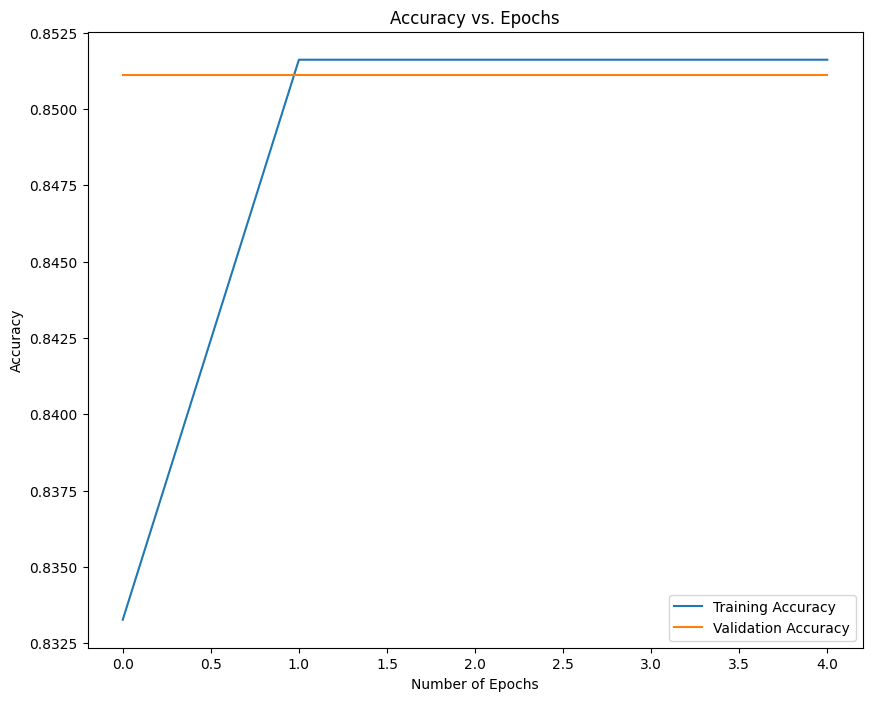

In [ ]:
plot_acc(num_epochs, train_acc, val_acc) #1e-3

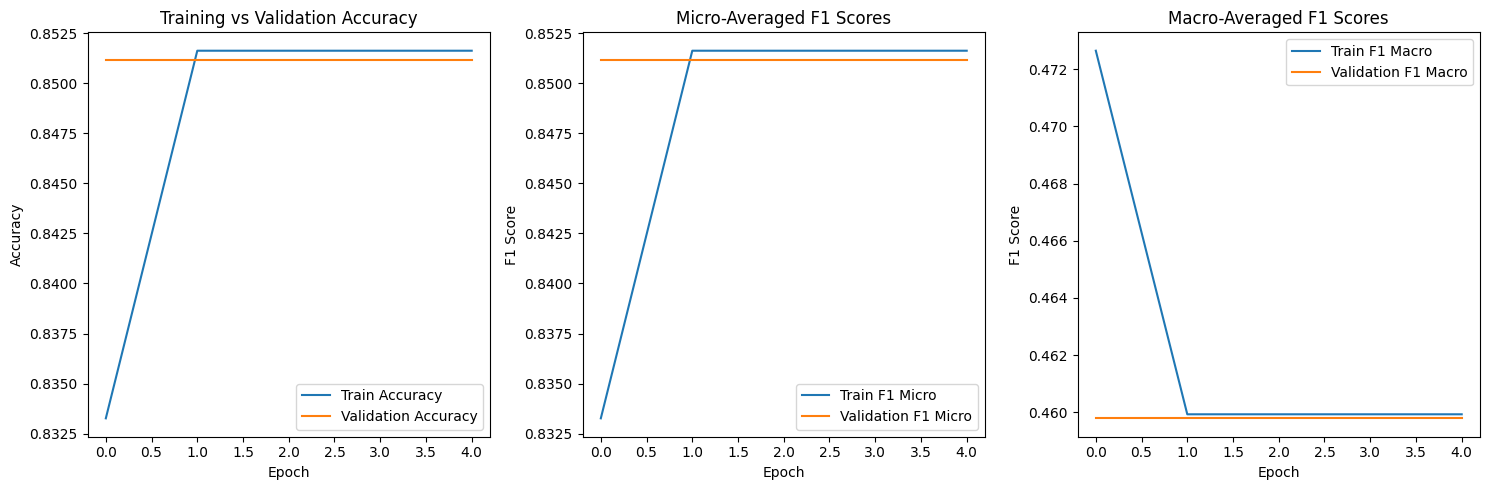

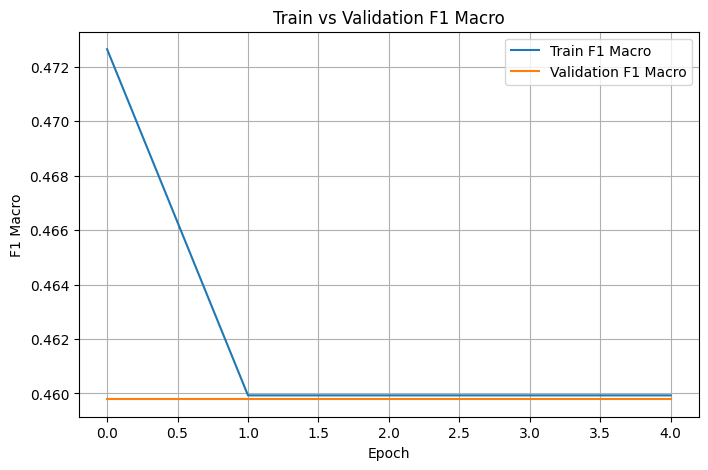

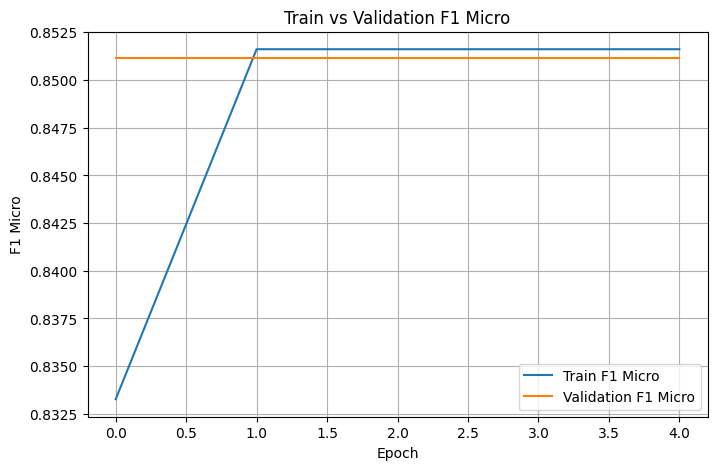

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics(num_epochs, train_acc, val_acc,
                         train_f1_micro, val_f1_micro,
                         train_f1_macro, val_f1_macro):
    """
    Plot accuracy and F1 scores (micro/macro) across epochs
    """
    plt.figure(figsize=(15, 5))

    # 1. Accuracy Plot
    plt.subplot(1, 3, 1)
    plt.plot(num_epochs, train_acc, label='Train Accuracy')
    plt.plot(num_epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # 2. F1 Micro Plot
    plt.subplot(1, 3, 2)
    plt.plot(num_epochs, train_f1_micro, label='Train F1 Micro')
    plt.plot(num_epochs, val_f1_micro, label='Validation F1 Micro')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Micro-Averaged F1 Scores')
    plt.legend()

    # 3. F1 Macro Plot
    plt.subplot(1, 3, 3)
    plt.plot(num_epochs, train_f1_macro, label='Train F1 Macro')
    plt.plot(num_epochs, val_f1_macro, label='Validation F1 Macro')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Macro-Averaged F1 Scores')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Add this after your training loop:
plot_training_metrics(num_epochs, train_acc, val_acc,
                     train_f1_micro, val_f1_micro,
                     train_f1_macro, val_f1_macro)

# Additional diagnostic plots
def plot_metric_comparison(num_epochs, train_metrics, val_metrics, metric_name):
    plt.figure(figsize=(8, 5))
    plt.plot(num_epochs, train_metrics, label=f'Train {metric_name}')
    plt.plot(num_epochs, val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title(f'Train vs Validation {metric_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compare macro vs micro F1
plot_metric_comparison(num_epochs, train_f1_macro, val_f1_macro, 'F1 Macro')
plot_metric_comparison(num_epochs, train_f1_micro, val_f1_micro, 'F1 Micro')

#BERT MODEL

### Load pre-trained DistilBERT model and tokenizer


In [103]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(df['source_genre'])

#transform target variable
y = mlb.transform(df['source_genre'])

In [104]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=mlb.classes_.shape[0])

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preprocess the text data using the tokenizer


In [102]:
text_data = df['CleanedOverview']
input_ids = []
attention_masks = []
encodings = tokenizer(list(text_data), truncation=True, padding=True, return_tensors='pt')
input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']

### Convert the lists to tensors


In [105]:
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)

<ipython-input-105-1be4e8e87b42>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
<ipython-input-105-1be4e8e87b42>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = torch.tensor(attention_masks)


In [106]:
# Set the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### Define the custom dataset class for our text data


In [100]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        input_id = self.input_ids[idx]
        attention_mask = self.attention_masks[idx]
        label = self.labels[idx]

        return {
            'input_ids': input_id,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

### Create the dataset and data loader


In [108]:
# Split input tensors and labels
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_masks, torch.tensor(y_bert), test_size=0.2, random_state=42
)

In [109]:
train_dataset = TextDataset(train_inputs, train_masks, train_labels)
val_dataset = TextDataset(val_inputs, val_masks, val_labels)
B_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
B_val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

###Set Hyperparameters

In [110]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Train the model


In [61]:
from sklearn.metrics import classification_report
all_preds = []
all_labels = []
for epoch in range(5):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in B_train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [batch_size, num_labels]
        loss = criterion(logits, labels.float())
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(logits) > 0.5
        correct += (preds == labels.bool()).sum().item()
        total += labels.numel()

    train_accuracy = correct / total
    print(f'Epoch {epoch+1}, Accuracy: {train_accuracy :.4f}')

    model.eval()
    with torch.no_grad():
        val_correct = 0
        val_total = 0

        for batch in B_val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.sigmoid(logits) > 0.5

            val_correct += (preds == labels.bool()).sum().item()
            val_total += labels.numel()

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    val_accuracy = val_correct / val_total if val_total > 0 else 0
    print(f'Epoch {epoch+1}, Validation Accuracy: {val_accuracy:.4f}')

# Convert predictions and labels to numpy arrays
all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Print classification report
print(classification_report(
    all_labels,
    all_preds,
    target_names=mlb.classes_,
    zero_division=0
))

NameError: name 'B_train_loader' is not defined

#LSTM + BERT Tokenizer

##Version1

In [86]:
csv_path = '/content/drive/MyDrive/ColabNotebooks/undersampled_TMDB.csv'
df = pd.read_csv(csv_path)
df.head()

,movie_id,title,overview,poster_path,poster_file,genres,title_length,overview_length,num_genre,source_genre,...,Documentary,Romance,Action,Thriller,Horror,Crime,Music,Animation,TV Movie,Family
0,86497,Wide Open,A philandering cab driver decides to help his ...,/uzIFp9Wu4QPyTJ1eqgkcIVYud7S.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Comedy', 'Drama']",9,114,2,"['Drama', 'Comedy']",...,0,0,0,0,0,0,0,0,0,0
1,16219,Gladiator,Tommy Riley has moved with his dad to Chicago ...,/w0YjBWVfu689txEXZG3xa4Aev3i.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Drama', 'Action']",9,236,2,"['Drama', 'Action']",...,0,0,1,0,0,0,0,0,0,0
2,512062,Vinayapoorvam Vidyadharan,"Vidyadharan is a bank employee, who loses his ...",/t4P0xquN818fyhMdsCsGR5BecV5.jpg,/content/drive/MyDrive/Tmdb_posters/movie_post...,"['Comedy', 'Family', 'Drama']",25,172,3,"['Drama', 'Comedy', 'Family']",...,0,0,0,0,0,0,0,0,0,1
3,43089,Roadgames,A truck driver plays a cat-and-mouse game with...,/zj3eE1lNkp3oWWnOHu4Aj7Gkqj2.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Thriller', 'Mystery', 'Horror']",9,158,2,"['Thriller', 'Horror']",...,0,0,0,1,1,0,0,0,0,0
4,270016,Elvis by the Presleys,"Priscilla Presley, her daughter, their family ...",/rdYML6V994npU7RKcnjijLIJ8Fj.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Music', 'Documentary']",21,152,2,"['Documentary', 'Music']",...,1,0,0,0,0,0,1,0,0,0


In [74]:
df.head()

,movie_id,title,overview,poster_path,poster_file,genres,title_length,overview_length,num_genre,source_genre,...,Documentary,Romance,Action,Thriller,Horror,Crime,Music,Animation,TV Movie,Family
0,86497,Wide Open,A philandering cab driver decides to help his ...,/uzIFp9Wu4QPyTJ1eqgkcIVYud7S.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Comedy', 'Drama']",9,114,2,"['Drama', 'Comedy']",...,0,0,0,0,0,0,0,0,0,0
1,16219,Gladiator,Tommy Riley has moved with his dad to Chicago ...,/w0YjBWVfu689txEXZG3xa4Aev3i.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Drama', 'Action']",9,236,2,"['Drama', 'Action']",...,0,0,1,0,0,0,0,0,0,0
2,512062,Vinayapoorvam Vidyadharan,"Vidyadharan is a bank employee, who loses his ...",/t4P0xquN818fyhMdsCsGR5BecV5.jpg,/content/drive/MyDrive/Tmdb_posters/movie_post...,"['Comedy', 'Family', 'Drama']",25,172,3,"['Drama', 'Comedy', 'Family']",...,0,0,0,0,0,0,0,0,0,1
3,43089,Roadgames,A truck driver plays a cat-and-mouse game with...,/zj3eE1lNkp3oWWnOHu4Aj7Gkqj2.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Thriller', 'Mystery', 'Horror']",9,158,2,"['Thriller', 'Horror']",...,0,0,0,1,1,0,0,0,0,0
4,270016,Elvis by the Presleys,"Priscilla Presley, her daughter, their family ...",/rdYML6V994npU7RKcnjijLIJ8Fj.jpg,/content/drive/MyDrive/Tmdb_posters_custom/mov...,"['Music', 'Documentary']",21,152,2,"['Documentary', 'Music']",...,1,0,0,0,0,0,1,0,0,0


In [87]:
#Merging above statements into a function
stop_words = set(stopwords.words('english'))
def clean_Overview(text):
  text = re.sub(r'[^a-zA-Z]',' ', text)
  text = str(text).lower()
  text = word_tokenize(text)
  text = [item for item in text if item not in stop_words]
  text = [lemma.lemmatize(word = w,pos='v') for w in text]
  text = [i for i in text if len(i) > 2]
  text = ' '.join(text)
  return text
df['CleanedOverview'] = df['overview'].apply(clean_Overview)

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

###Dataset Preprocessing

In [89]:
# If genre is still string type
df = df.reset_index(drop=True)
if isinstance(df['source_genre'].iloc[0], str):
    df['source_genre'] = df['source_genre'].str.strip("[]").str.replace("'", "").str.split(", ")

# Binarize labels
mlb = MultiLabelBinarizer()
df['labels'] = mlb.fit_transform(df['source_genre']).tolist()
# Ensure labels are proper lists, not strings
df['labels'] = df['labels'].apply(lambda x: list(map(int, x)) if isinstance(x, list) else x)
# Split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Reset index to avoid KeyError during lookup
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Extract inputs and labels separately
train_texts = train_df['CleanedOverview'].tolist()
val_texts = val_df['CleanedOverview'].tolist()
y_train = train_df['labels'].tolist()
y_val = val_df['labels'].tolist()

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 256

#Dataset and Dataloader

In [78]:
row = df.iloc[0]
text = row['CleanedOverview']
text

'philander cab driver decide help girlfriend attractive sister trouble drug dealers'

In [90]:
class MovieDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'labels': torch.FloatTensor(self.labels[idx])
        }
def tokenize_for_lstm(texts, tokenizer, max_len=128):
    input_ids = []
    for text in texts:
        encoding = tokenizer(text, max_length=max_len, padding='max_length', truncation=True, return_tensors='pt')
        input_ids.append(encoding['input_ids'].flatten())
    return torch.stack(input_ids)

# Prepare data for LSTM
train_input = tokenize_for_lstm(train_texts, tokenizer).to(device)
val_input = tokenize_for_lstm(val_texts, tokenizer).to(device)

train_dataset = MovieDataset(train_input, y_train)
val_dataset = MovieDataset(val_input, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [91]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, vocab_size,freeze_embedding):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if freeze_embedding:
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                           num_layers=2,  # Add more layers
                           bidirectional=True,  # Use bidirectional
                           batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Use the last hidden state
        x = self.dropout(x)
        out = self.fc(x)
        return out

##Training and Evaluation

In [92]:
from sklearn.metrics import f1_score

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_f1 = 0, 0, 0
    all_preds, all_labels = [], []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = (outputs > 0.5).float()
        total_loss += loss.item()
        total_correct += (preds == labels.bool()).sum().item() / (labels.numel())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    return total_loss / len(dataloader), total_correct / len(dataloader), avg_f1

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            # attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            preds = torch.sigmoid(outputs) > 0.5
            total_loss += loss.item()
            total_correct += (preds == labels.bool()).sum().item() / (labels.numel())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    return total_loss / len(dataloader), total_correct / len(dataloader), avg_f1, all_preds, all_labels


In [66]:
baseline_model = nn.Sequential(
    nn.Linear(tokenizer.vocab_size, output_dim)
).to(device)

,CleanedOverview
0,philander cab driver decide help girlfriend at...
1,tommy riley move dad chicago nice place keep s...
2,vidyadharan bank employee lose job due wife ex...
3,truck driver play cat mouse game mysterious se...
4,priscilla presley daughter family friends open...
...,...
23640,plover chick learn fly family migrate fall mus...
23641,make documentary uzak distant show film makers...
23642,trail cold murder investigation policeman unde...
23643,ella divorce chinese american taxi driver spen...


#Hyperparamters and Training

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 32
output_dim = len(mlb.classes_)
num_epochs = 10

model = LSTMModel(embedding_dim, hidden_dim, output_dim, vocab_size).to(device)
# Calculate class weights
label_matrix = mlb.transform(df['source_genre'])
pos_counts = label_matrix.sum(axis=0)
neg_counts = len(label_matrix) - pos_counts
class_weights = neg_counts / pos_counts

# Apply to loss function
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
# criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Lower LR
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1, val_preds, val_targets = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f}, F1: {train_f1:.4f} | Val Acc: {val_acc:.4f}, F1: {val_f1:.4f}")


Epoch 1/10 | Train Loss: 1.1804 | Val Loss: 1.1822
Train Acc: 0.1483, F1: 0.2584 | Val Acc: 0.4936, F1: 0.2196
Epoch 2/10 | Train Loss: 1.1802 | Val Loss: 1.1822
Train Acc: 0.1483, F1: 0.2584 | Val Acc: 0.4937, F1: 0.2197
Epoch 3/10 | Train Loss: 1.1802 | Val Loss: 1.1821
Train Acc: 0.1484, F1: 0.2584 | Val Acc: 0.4867, F1: 0.2088
Epoch 4/10 | Train Loss: 1.1806 | Val Loss: 1.1821
Train Acc: 0.1484, F1: 0.2584 | Val Acc: 0.5507, F1: 0.2055
Epoch 5/10 | Train Loss: 1.1804 | Val Loss: 1.1821
Train Acc: 0.1484, F1: 0.2584 | Val Acc: 0.4905, F1: 0.2147
Epoch 6/10 | Train Loss: 1.1801 | Val Loss: 1.1821
Train Acc: 0.1484, F1: 0.2584 | Val Acc: 0.4240, F1: 0.2132
Epoch 7/10 | Train Loss: 1.1799 | Val Loss: 1.1821
Train Acc: 0.1483, F1: 0.2584 | Val Acc: 0.5508, F1: 0.2056
Epoch 8/10 | Train Loss: 1.1802 | Val Loss: 1.1821
Train Acc: 0.1484, F1: 0.2584 | Val Acc: 0.6135, F1: 0.1986
Epoch 9/10 | Train Loss: 1.1798 | Val Loss: 1.1821
Train Acc: 0.1483, F1: 0.2584 | Val Acc: 0.6135, F1: 0.1987
E

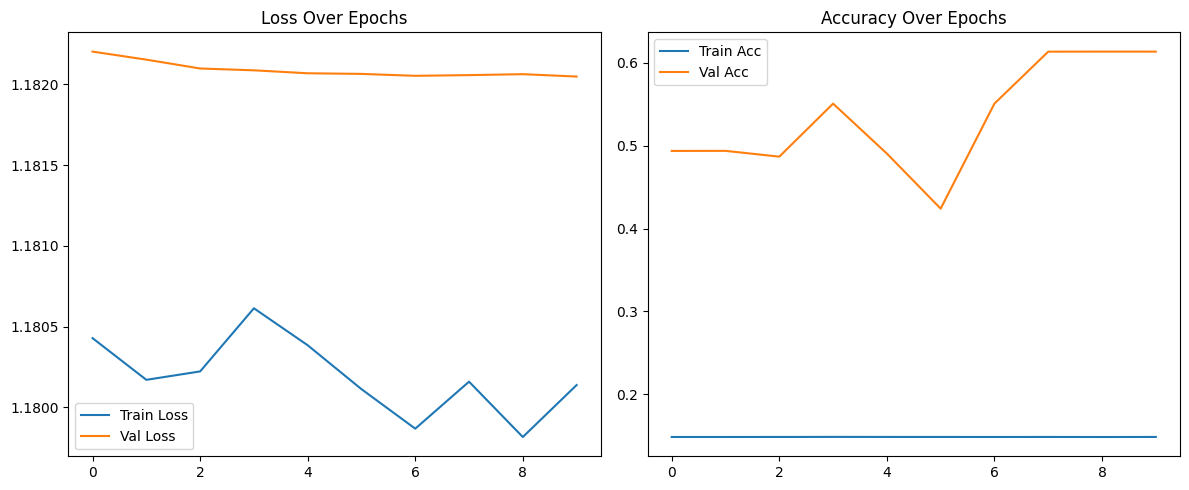

In [69]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

      Action       0.17      0.00      0.00       777
   Animation       0.00      0.00      0.00       653
      Comedy       0.33      0.00      0.00       911
       Crime       0.10      1.00      0.18       465
 Documentary       0.20      1.00      0.33       939
       Drama       0.00      0.00      0.00      1015
      Family       0.11      1.00      0.20       539
      Horror       0.00      0.00      0.00       739
       Music       0.30      0.01      0.01       584
     Romance       0.00      0.00      0.00       582
    TV Movie       0.00      0.00      0.00       474
    Thriller       0.16      1.00      0.28       770

   micro avg       0.14      0.32      0.20      8448
   macro avg       0.11      0.33      0.08      8448
weighted avg       0.12      0.32      0.09      8448
 samples avg       0.14      0.34      0.19      8448



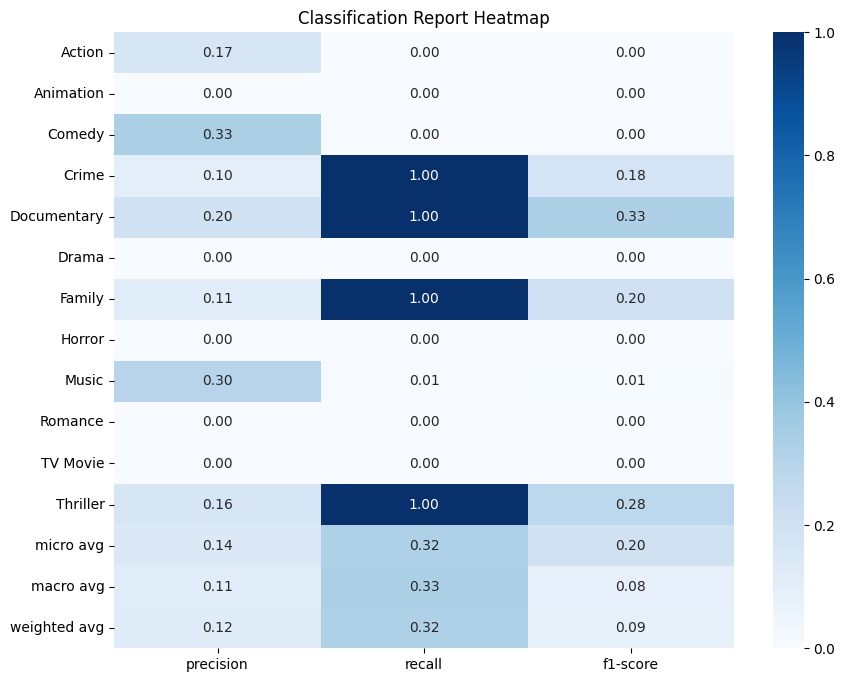

In [72]:
from sklearn.metrics import classification_report, confusion_matrix

# Flatten predictions and targets for multi-label
val_preds_flat = np.vstack(val_preds).astype(int)
val_targets_flat = np.vstack(val_targets).astype(int)

# Classification Report
report = classification_report(val_targets_flat, val_preds_flat, target_names=mlb.classes_, zero_division=0, output_dict=True)
print(classification_report(val_targets_flat, val_preds_flat, target_names=mlb.classes_, zero_division=0))

# Heatmap
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Report Heatmap")
plt.show()

#Version2

#Hyperparamters and Training

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 64
output_dim = len(mlb.classes_)
num_epochs = 10

model = LSTMModel(embedding_dim, hidden_dim, output_dim, vocab_size,freeze_embedding=True).to(device)
# Calculate class weights
label_matrix = mlb.transform(df['source_genre'])
pos_counts = label_matrix.sum(axis=0)
neg_counts = len(label_matrix) - pos_counts
class_weights = neg_counts / pos_counts

# Apply to loss function
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
# criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Lower LR
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1, val_preds, val_targets = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f}, F1: {train_f1:.4f} | Val Acc: {val_acc:.4f}, F1: {val_f1:.4f}")


Epoch 1/10 | Train Loss: 1.1806 | Val Loss: 1.1822
Train Acc: 0.8516, F1: 0.0000 | Val Acc: 0.5533, F1: 0.2102
Epoch 2/10 | Train Loss: 1.1803 | Val Loss: 1.1821
Train Acc: 0.8516, F1: 0.0000 | Val Acc: 0.5563, F1: 0.2152
Epoch 3/10 | Train Loss: 1.1804 | Val Loss: 1.1821
Train Acc: 0.8516, F1: 0.0000 | Val Acc: 0.5621, F1: 0.2259
Epoch 4/10 | Train Loss: 1.1801 | Val Loss: 1.1820
Train Acc: 0.8516, F1: 0.0004 | Val Acc: 0.6184, F1: 0.2085
Epoch 5/10 | Train Loss: 1.1801 | Val Loss: 1.1820
Train Acc: 0.8516, F1: 0.0007 | Val Acc: 0.4525, F1: 0.2514
Epoch 6/10 | Train Loss: 1.1800 | Val Loss: 1.1820
Train Acc: 0.8516, F1: 0.0007 | Val Acc: 0.5624, F1: 0.2260
Epoch 7/10 | Train Loss: 1.1804 | Val Loss: 1.1820
Train Acc: 0.8515, F1: 0.0007 | Val Acc: 0.5529, F1: 0.2083
Epoch 8/10 | Train Loss: 1.1796 | Val Loss: 1.1819
Train Acc: 0.8517, F1: 0.0008 | Val Acc: 0.5628, F1: 0.2261
Epoch 9/10 | Train Loss: 1.1783 | Val Loss: 1.1774
Train Acc: 0.8503, F1: 0.0074 | Val Acc: 0.4488, F1: 0.2468
E

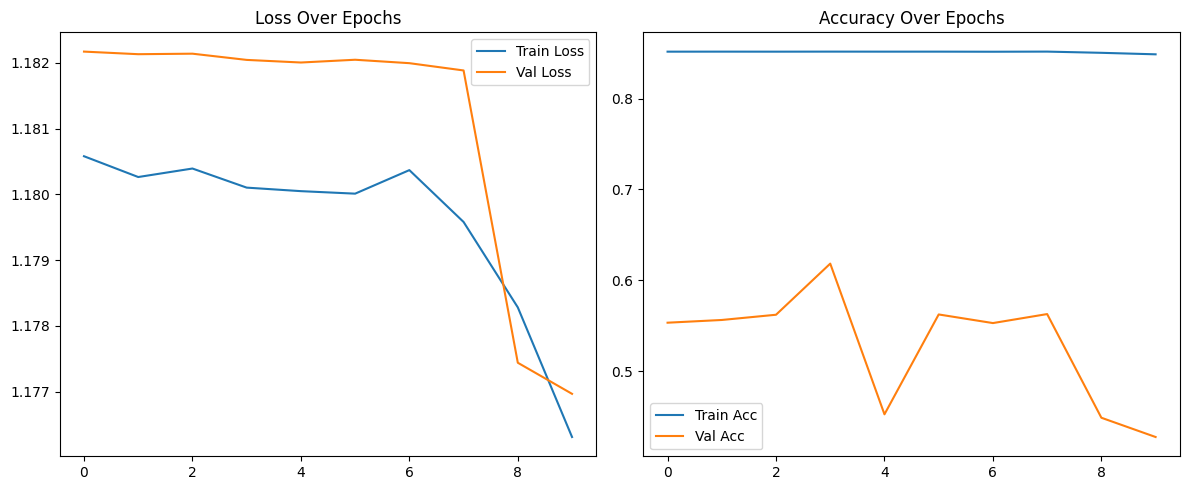

In [94]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00       777
   Animation       0.17      0.22      0.19       653
      Comedy       0.20      0.88      0.32       911
       Crime       0.10      0.89      0.19       465
 Documentary       0.27      0.23      0.25       939
       Drama       0.22      0.83      0.35      1015
      Family       0.11      1.00      0.20       539
      Horror       0.17      0.90      0.29       739
       Music       0.18      0.22      0.20       584
     Romance       0.13      0.89      0.22       582
    TV Movie       0.10      0.87      0.19       474
    Thriller       0.18      0.89      0.29       770

   micro avg       0.15      0.64      0.25      8448
   macro avg       0.15      0.65      0.22      8448
weighted avg       0.16      0.64      0.23      8448
 samples avg       0.16      0.60      0.24      8448



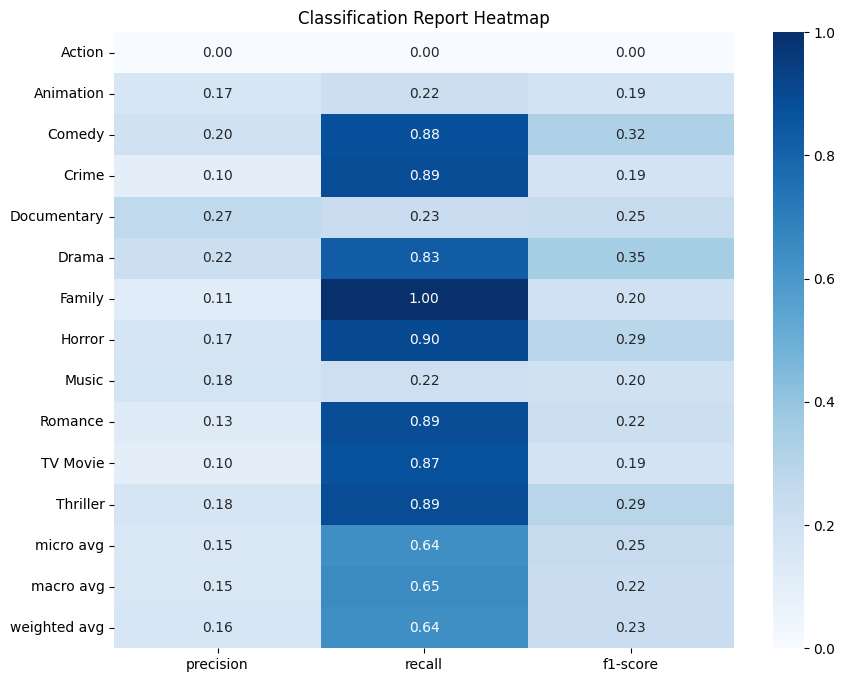

In [95]:
from sklearn.metrics import classification_report, confusion_matrix

# Flatten predictions and targets for multi-label
val_preds_flat = np.vstack(val_preds).astype(int)
val_targets_flat = np.vstack(val_targets).astype(int)

# Classification Report
report = classification_report(val_targets_flat, val_preds_flat, target_names=mlb.classes_, zero_division=0, output_dict=True)
print(classification_report(val_targets_flat, val_preds_flat, target_names=mlb.classes_, zero_division=0))

# Heatmap
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Report Heatmap")
plt.show()